# Prueba Tecnica Cientifico de datos - Proceso de seleccion BdB

**Enunciado:**

Se adjunta un data set con pacientes que podrían o no, tener cáncer cervical (positivo en una biopsia).

El experto de negocio nos advirtió que no le importa si algunas dimensiones no aportan información relevante en un modelo ML, él quiere que todas se incluyan.

El objetivo del ejercicio es poder obtener un modelo consistente que pueda predecir/diagnosticar el resultado de una biopsia dada la información de algún paciente.

Para más información del dataset, puede consultar el siguiente [link](https://archive.ics.uci.edu/dataset/383/cervical+cancer+risk+factors)


In [1]:
#!pip install -r requirements.txt

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Missing values
import missingno as msno

from sklearn.model_selection import train_test_split

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer


from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Oversampling
from sklearn.utils import resample

# Balanced Data
from imblearn.over_sampling import SMOTE

# Additionals
import json

# Preprocesamiento

Dada la descripcion del conjunto de datos:

----
The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela. The dataset comprises demographic information, habits, and historic medical records of 858 patients. Several patients decided not to answer some of the questions because of privacy concerns (missing values).

----
[Fernandes,Kelwin, Cardoso,Jaime, and Fernandes,Jessica. (2017). Cervical Cancer (Risk Factors). UCI Machine Learning Repository.](https://doi.org/10.24432/C5Z310)


Podemos observar que el data set cuenta con datos faltantes debido a que algunos pacientes se abstuvieron de responder por políticas de privacidad.

In [3]:
df_RFCC = pd.read_csv('risk_factors_cervical_cancer.csv', na_values="?")
df_RFCC.head()

Age  Number of sexual partners  First sexual intercourse  \
0   18                        4.0                      15.0   
1   15                        1.0                      14.0   
2   34                        1.0                       NaN   
3   52                        5.0                      16.0   
4   46                        3.0                      21.0   

   Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                 1.0     0.0             0.0                  0.0   
1                 1.0     0.0             0.0                  0.0   
2                 1.0     0.0             0.0                  0.0   
3                 4.0     1.0            37.0                 37.0   
4                 4.0     0.0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (years)  IUD  ...  \
0                      0.0                              0.0  0.0  ...   
1                      0.0                              0.0  0.0  ...   
2                      0.0                              0.0  0.0  ...   
3                      1.0                              3.0  0.0  ...   
4                      1.0                             15.0  0.0  ...   

   STDs: Time since first diagnosis  STDs: Time since last diagnosis  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               NaN                              NaN   
4                               NaN                              NaN   

   Dx:Cancer  Dx:CIN  Dx:HPV  Dx  Hinselmann  Schiller  Citology  Biopsy  
0          0       0       0   0           0         0         0       0  
1          0       0       0   0           0         0         0       0  
2          0       0       0   0           0         0         0       0  
3          1       0       1   0           0         0         0       0  
4          0       0       0   0           0         0         0       0  

[5 rows x 36 columns]

## Imputación de datos

### Validación del supuesto de falta de información

La descripción del conjunto de datos nos sugiere que los datos faltantes pueden ser MNAR (Missing Not At Random - Falta no aleatoria de datos), es decir, la probabilidad de que un valor esté perdido puede depender del valor de la misma variable. En otras palabras, la falta de información está relacionada con la misma información que describe. Por ello, estos datos se clasifican también como non-ignorable-missingness o informative-missingness, lo que nos quiere decir que estos valores faltantes no deben ser eliminados, porque de lo contrario, esto llevaría a tener una información sesgada y sistemáticamente distorsionada de la distribución condicional.

Teniendo en cuenta las tres principales suposiciones de por qué los valores están perdidos (MCAR - Missing Completely At Random, MAR - Missing At Random y MNAR - Missing Not At Random), se busca tener un grado de certeza sobre la suposición de perdida no aleatoria de datos (MNAR).

Para ello, se seguirá el siguiente proceso:


1. Validar el número faltante de datos por característica (columna) y el total.
2. Determinar mediante una validación empírica el tipo de causa de información.

#### Número faltante de datos

In [4]:
def missing_values_percentage(df):
    # Count the missing values per column
    missing_values_count = df.isna().sum()
    # Calculate the percentage of missing values per column
    missing_values_percentage = (missing_values_count / len(df)) * 100
    # Create a DataFrame with the previous information
    missing_values = pd.DataFrame({'missing_values_count': missing_values_count, 'missing_values_percentage': missing_values_percentage})
    # Sort the dataframe Higher to lower
    missing_values = missing_values.sort_values(by='missing_values_percentage', ascending=False)
    # Get only the columns that have missing values
    missing_values = missing_values[missing_values['missing_values_count'] > 0]
    # Add a total row
    missing_values.at['Total of missing values', 'missing_values_count'] = missing_values_count.sum()
    missing_values.at['Total of missing values', 'missing_values_percentage'] = (missing_values_count.sum() / (len(df) * len(df.columns))) * 100
    # Add more information: Number of columns with missing values
    num_columns_with_missing_values = len(missing_values)
    missing_values.at['Total of columns with missing values', 'missing_values_count'] = num_columns_with_missing_values
    missing_values.at['Total of columns with missing values', 'missing_values_percentage'] = (num_columns_with_missing_values / len(df.columns)) * 100
    # Round the percentage to 2 decimal places
    missing_values = missing_values.round(2)
    return missing_values

In [5]:
df_RFCC.shape

(858, 36)

In [6]:
missing_values = missing_values_percentage(df_RFCC)
missing_values

missing_values_count  \
STDs: Time since first diagnosis                     787.0   
STDs: Time since last diagnosis                      787.0   
IUD                                                  117.0   
IUD (years)                                          117.0   
Hormonal Contraceptives                              108.0   
Hormonal Contraceptives (years)                      108.0   
STDs:HPV                                             105.0   
STDs:AIDS                                            105.0   
STDs:Hepatitis B                                     105.0   
STDs:HIV                                             105.0   
STDs                                                 105.0   
STDs:cervical condylomatosis                         105.0   
STDs:vulvo-perineal condylomatosis                   105.0   
STDs:syphilis                                        105.0   
STDs:pelvic inflammatory disease                     105.0   
STDs:vaginal condylomatosis                          105.0   
STDs:genital herpes                                  105.0   
STDs:molluscum contagiosum                           105.0   
STDs:condylomatosis                                  105.0   
STDs (number)                                        105.0   
Num of pregnancies                                    56.0   
Number of sexual partners                             26.0   
Smokes                                                13.0   
Smokes (packs/year)                                   13.0   
Smokes (years)                                        13.0   
First sexual intercourse                               7.0   
Total of missing values                             3622.0   
Total of columns with missing values                  27.0   

                                      missing_values_percentage  
STDs: Time since first diagnosis                          91.72  
STDs: Time since last diagnosis                           91.72  
IUD                                                       13.64  
IUD (years)                                               13.64  
Hormonal Contraceptives                                   12.59  
Hormonal Contraceptives (years)                           12.59  
STDs:HPV                                                  12.24  
STDs:AIDS                                                 12.24  
STDs:Hepatitis B                                          12.24  
STDs:HIV                                                  12.24  
STDs                                                      12.24  
STDs:cervical condylomatosis                              12.24  
STDs:vulvo-perineal condylomatosis                        12.24  
STDs:syphilis                                             12.24  
STDs:pelvic inflammatory disease                          12.24  
STDs:vaginal condylomatosis                               12.24  
STDs:genital herpes                                       12.24  
STDs:molluscum contagiosum                                12.24  
STDs:condylomatosis                                       12.24  
STDs (number)                                             12.24  
Num of pregnancies                                         6.53  
Number of sexual partners                                  3.03  
Smokes                                                     1.52  
Smokes (packs/year)                                        1.52  
Smokes (years)                                             1.52  
First sexual intercourse                                   0.82  
Total of missing values                                   11.73  
Total of columns with missing values                      75.00

Podemos observar que de las 36 columnas con las que cuenta el dataframe 27, de ellas tienen datos faltantes, donde, las que tienen menor información (número de registros) son las columnas *STDs: Time since last diagnosis* y  *STDs: Time since first diagnosis*. Adicionalmente, podemos observar que las columnas asociadas a información sobre enfermedades de transmisión sexual tienen en promedio 12 % de datos faltantes.

Visualmente, los registros por columna lucen de la siguiente manera:

<Axes: >

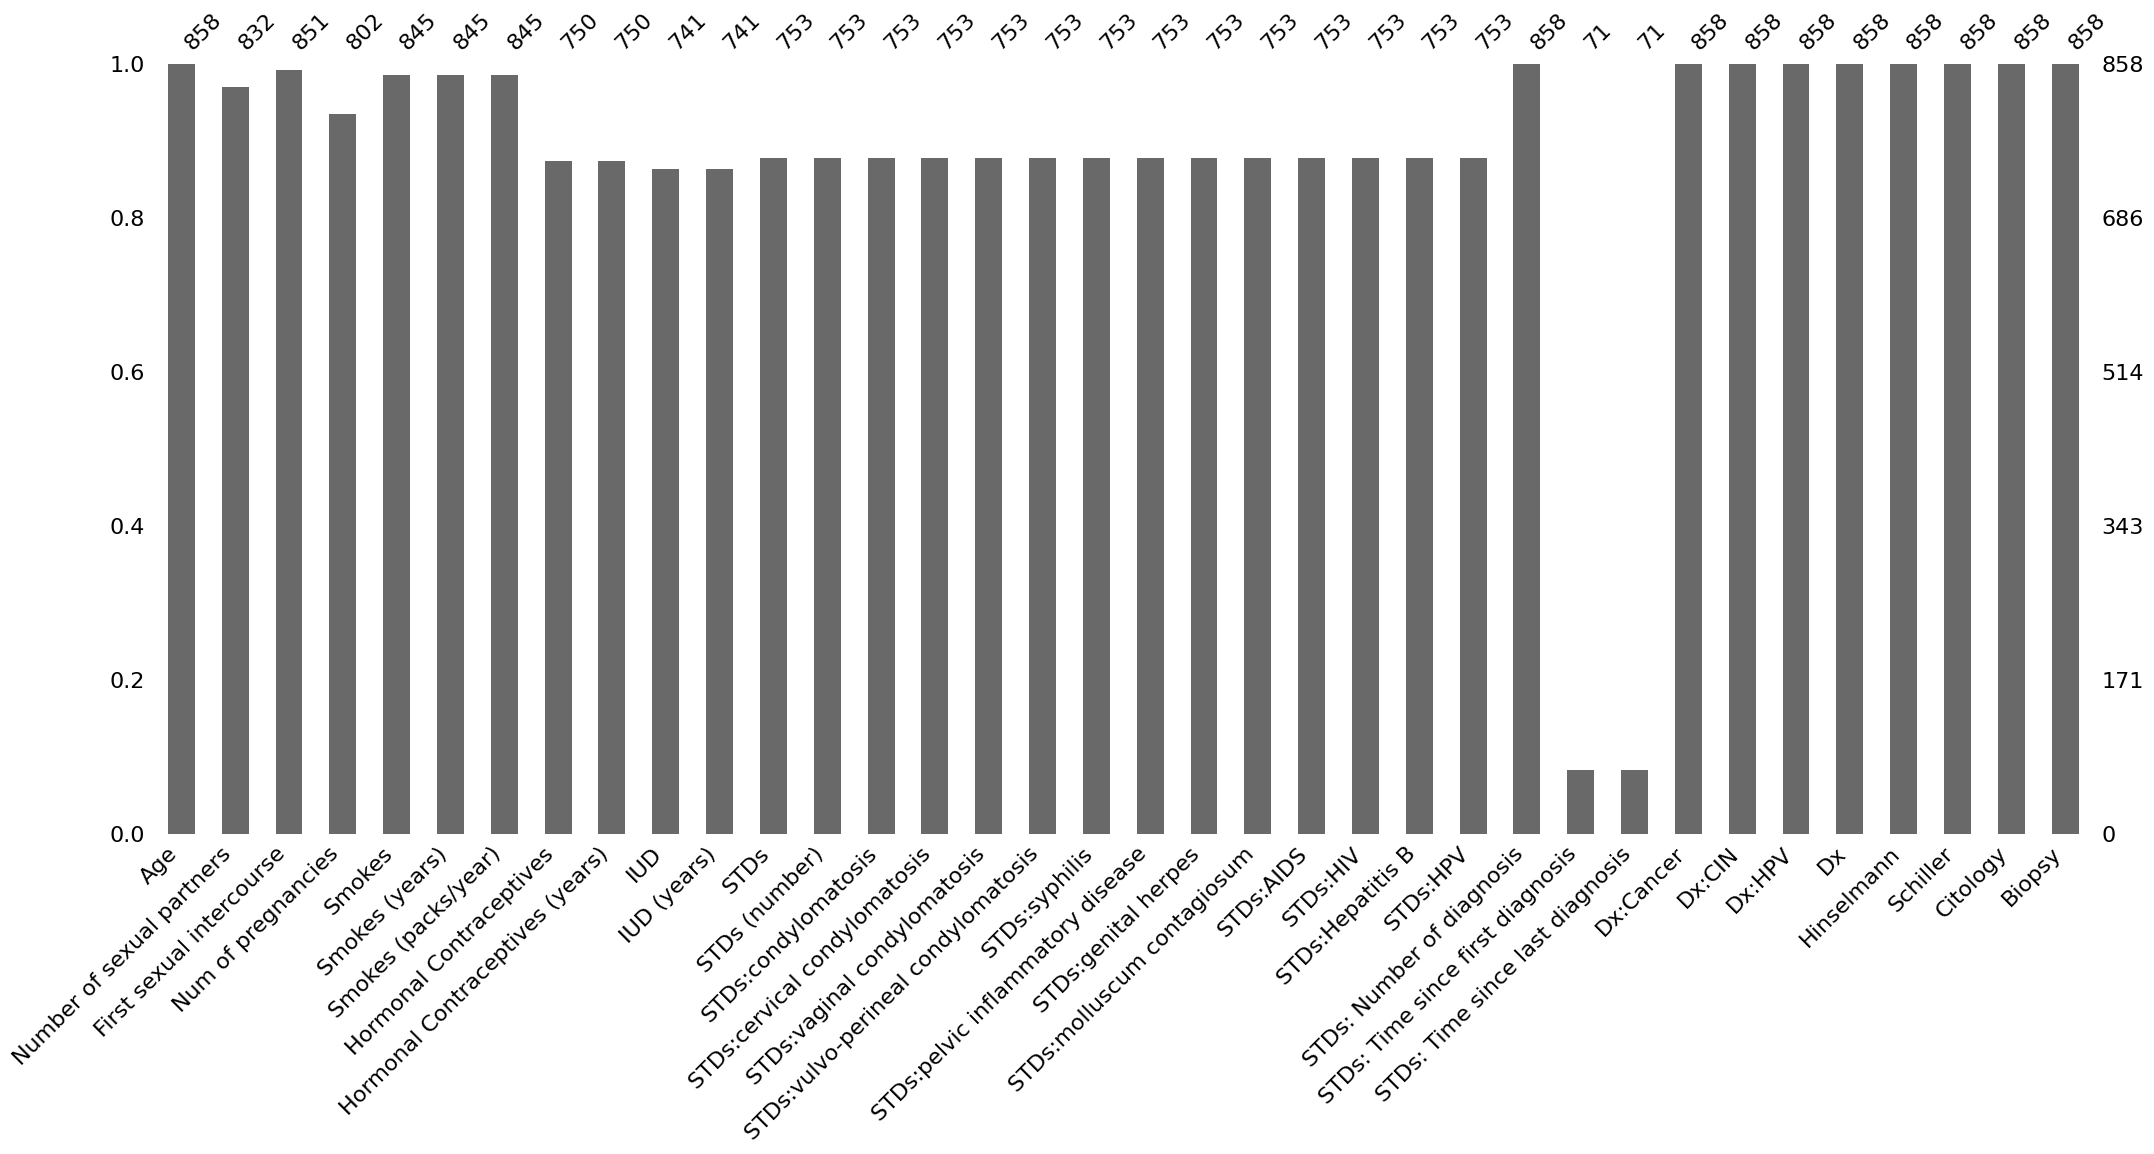

In [7]:
msno.bar(df_RFCC)

#### Validación empírica de los datos faltantes

Como parte de las validaciones a realizar para asumir con un mayor grado de certeza la razón de la falta de datos, se realizarán diferentes validaciones visuales. Para ello, primero se visualiza la ubicación de los datos faltantes.

<Axes: >

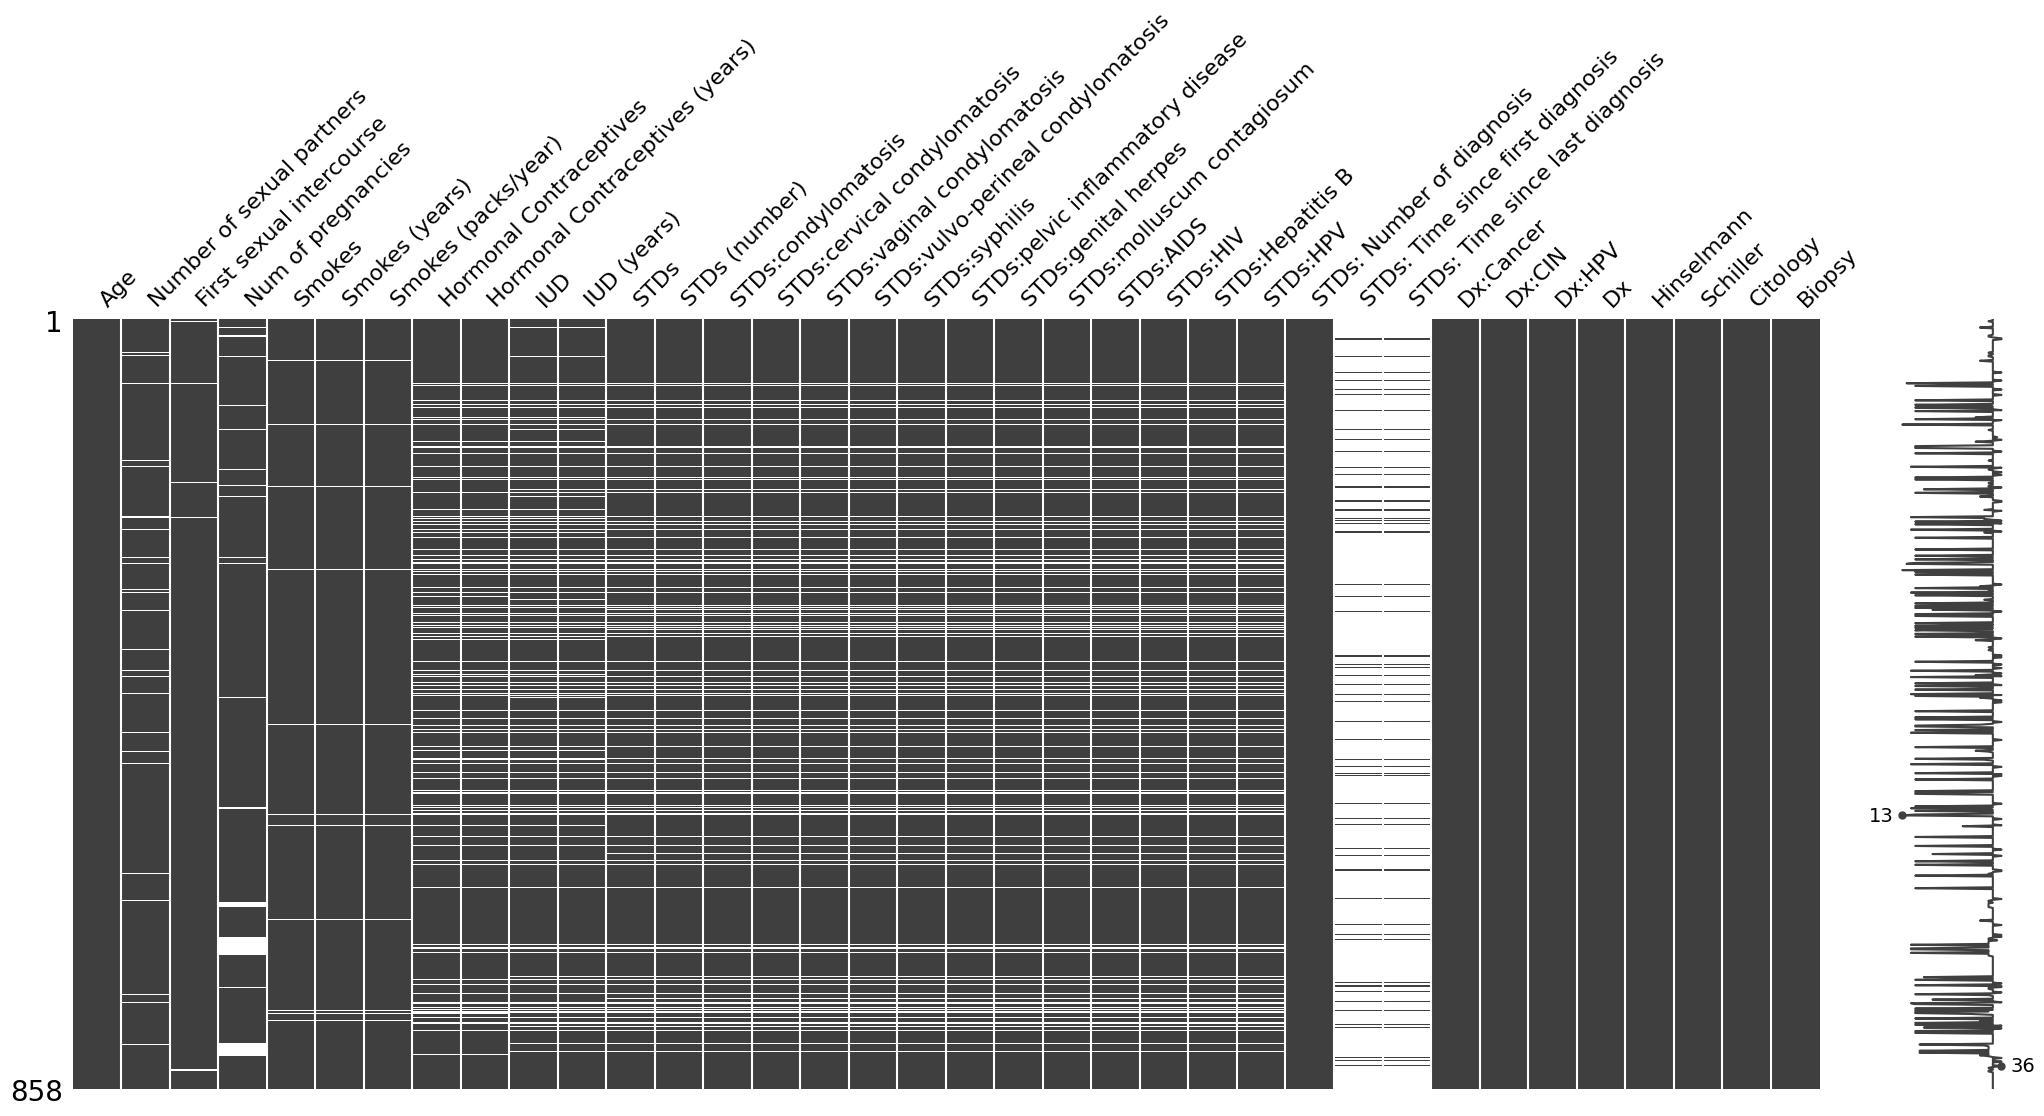

In [8]:
# Visualize missing data pattern
msno.matrix(df_RFCC)

Del registro de información faltante, podemos asumir que hay una correlación entre las variables relacionadas a STDs (enfermedades de transmisión sexual), excluyendo las columnas STDs: Time since last diagnosis y STDs: Time since first diagnosis, las cuales visualmente se puede decir que se correlacionan entre sí. En búsqueda de visualizar un patrón más claro de las premisas anteriores. Realizamos una nueva visualización de los datos ordenados esta vez por edad.

<Axes: >

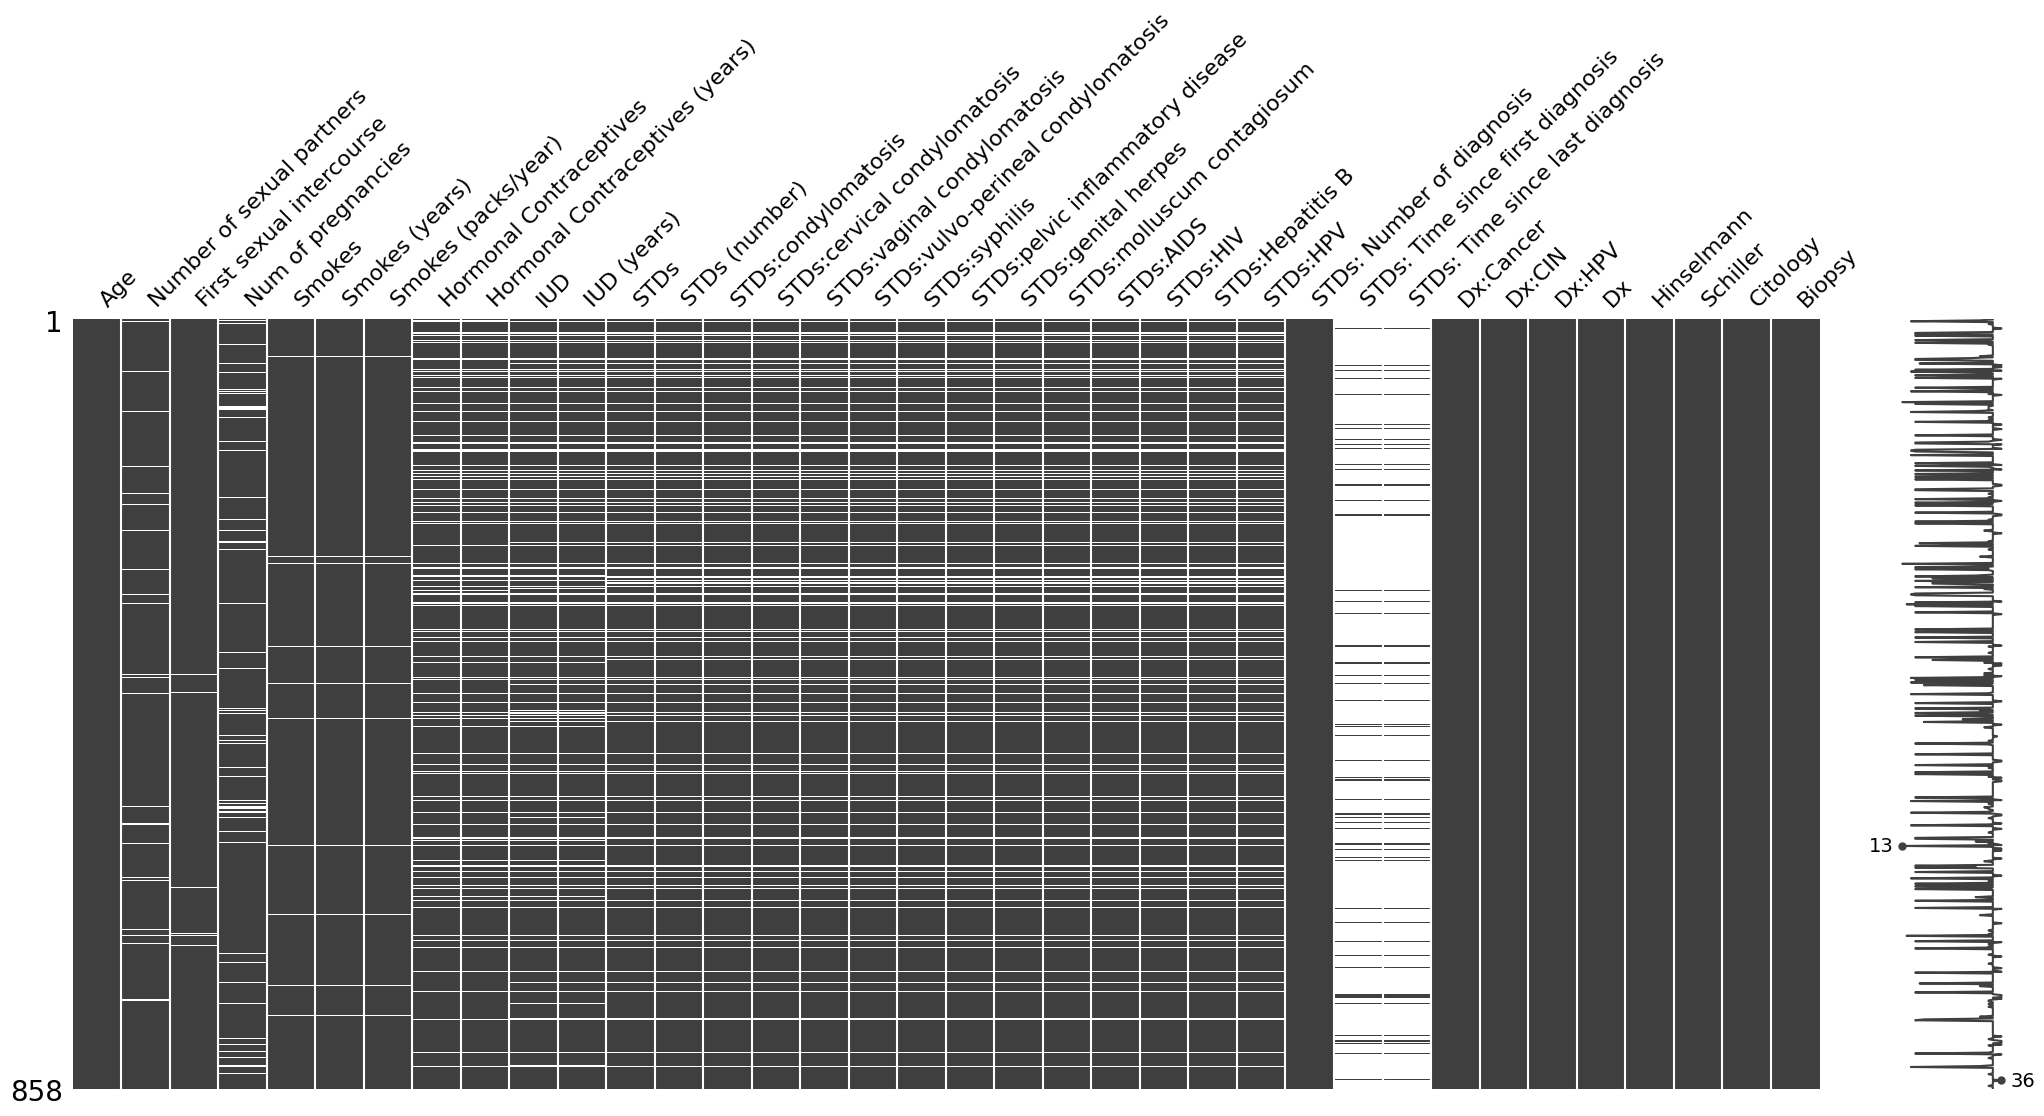

In [9]:
msno.matrix(df_RFCC.sort_values(by='Age'))

Podemos observar que se siguen las premisas anteriores.


* Correlación entre las variables relacionadas a STDs (enfermedades de transmisión sexual).
* Las columnas STDs: Time since last diagnosis y STDs: Time since first diagnosis, visualmente se puede decir que se correlacionan entre sí. Note que estas son las que tienen el mayor número de registros nulos.

Con el fin de reforzar estas premisas, se visualiza a continuación un mapa de calor donde se indica la correlación entre los valores faltantes de las diferentes características.

<Axes: >

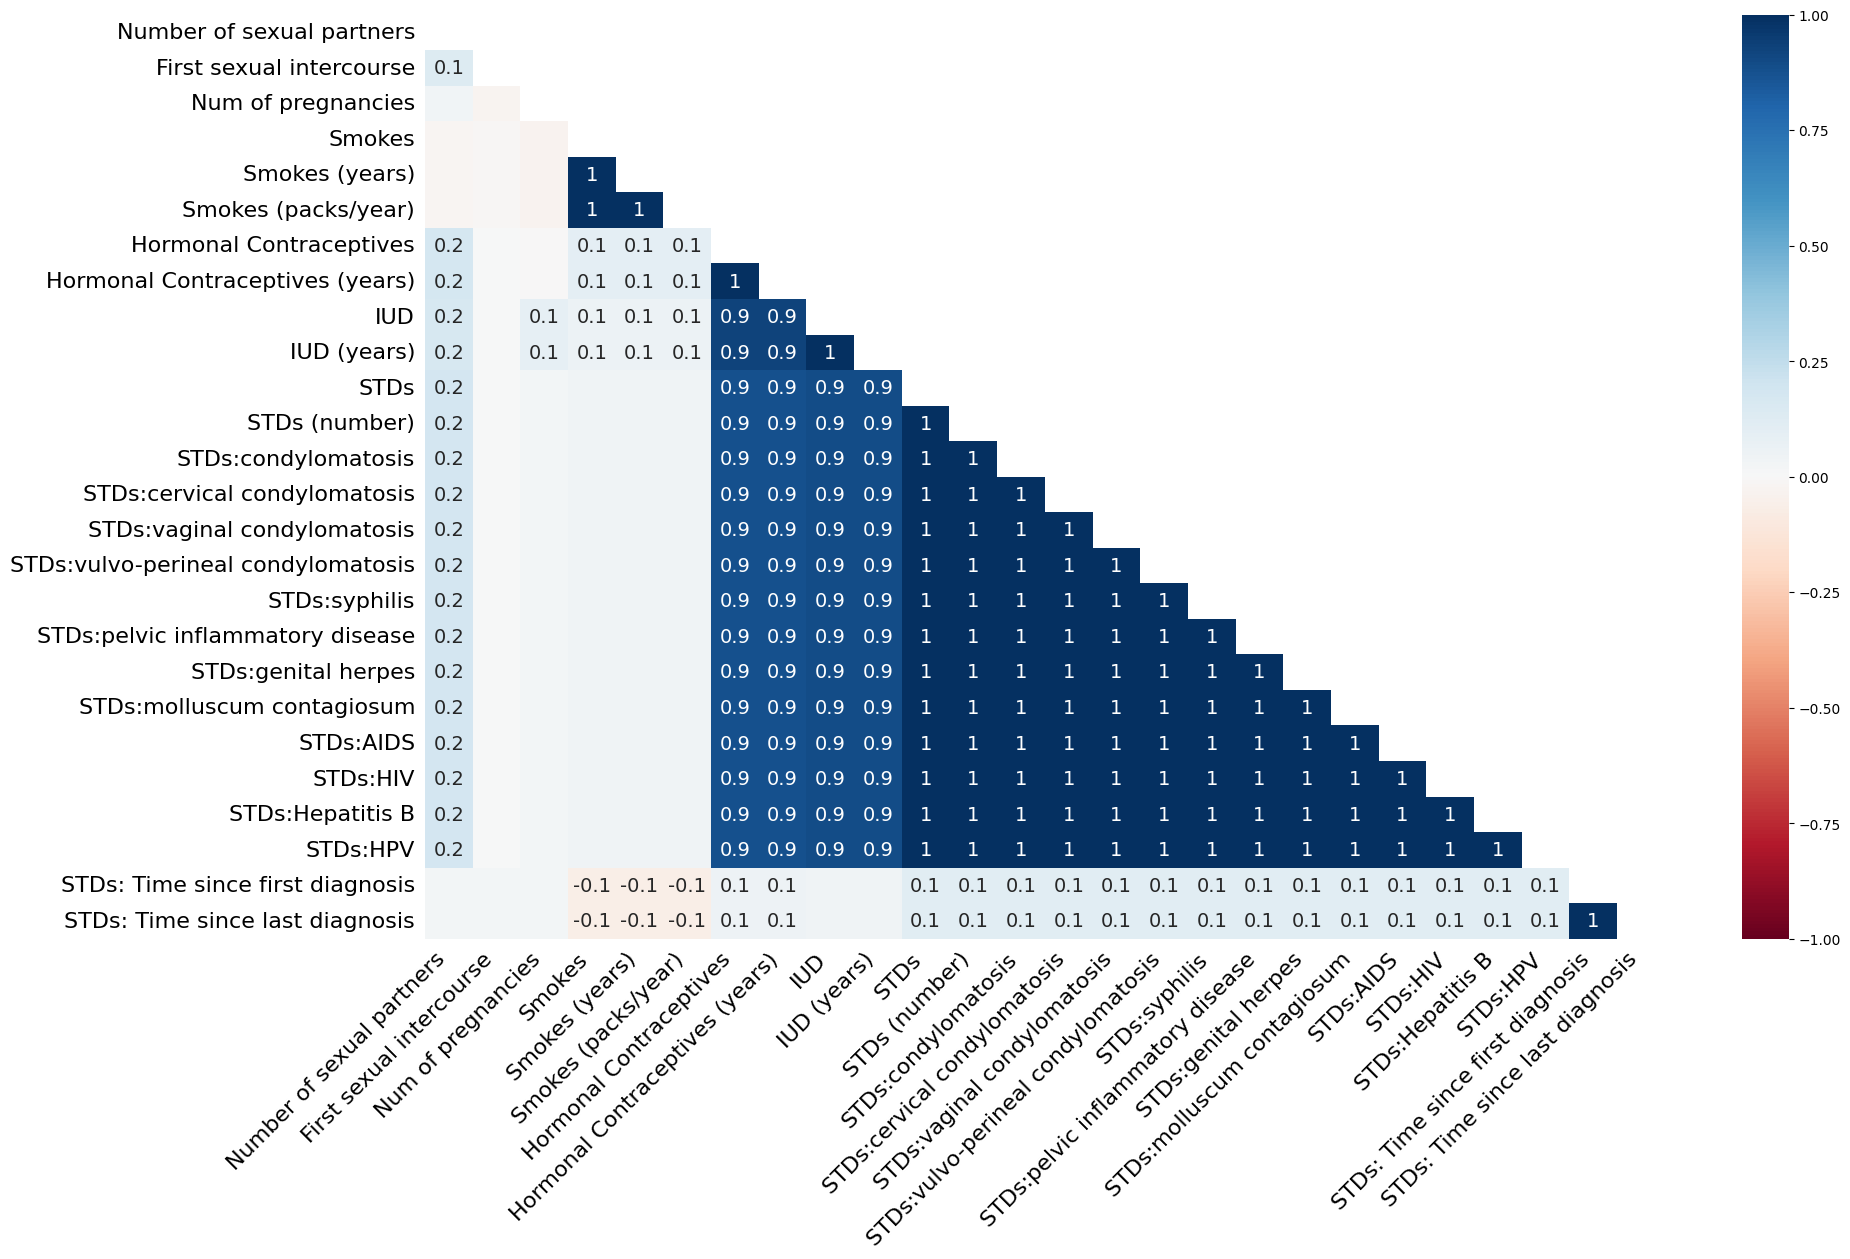

In [10]:
msno.heatmap(df_RFCC)

Dado el gráfico, podemos realizar las siguientes observaciones:

* Las variables *Number of sexual partners*, *First Sexual Intercourse*, *Num of pregnancies* muestran que no existe una fuerte correlación entre los valores faltantes respecto a las demás características. Lo cual nos indica que la falta de esta información es MAR (Missing At Random).
* Las variables *STDs: Time since first diagnosis* y *STDs: Time since last diagnosis* solo muestran una fuerte correlación entre sí, como era de esperarse. Sin embargo, dada la poca información registrada, no se puede realizar una suposición con cierto grado de certeza sobre la falta de esta información.
* Las variables restantes muestran una fuerte correlación entre sí. Lo cual nos indica que la falta de esta información es MNAR (Missing Not At Random).

Para completar este analisis, se realiza un dendograma, donde las variables agrupadas en el nivel 0, estan altamente correlacionadas.

<Axes: >

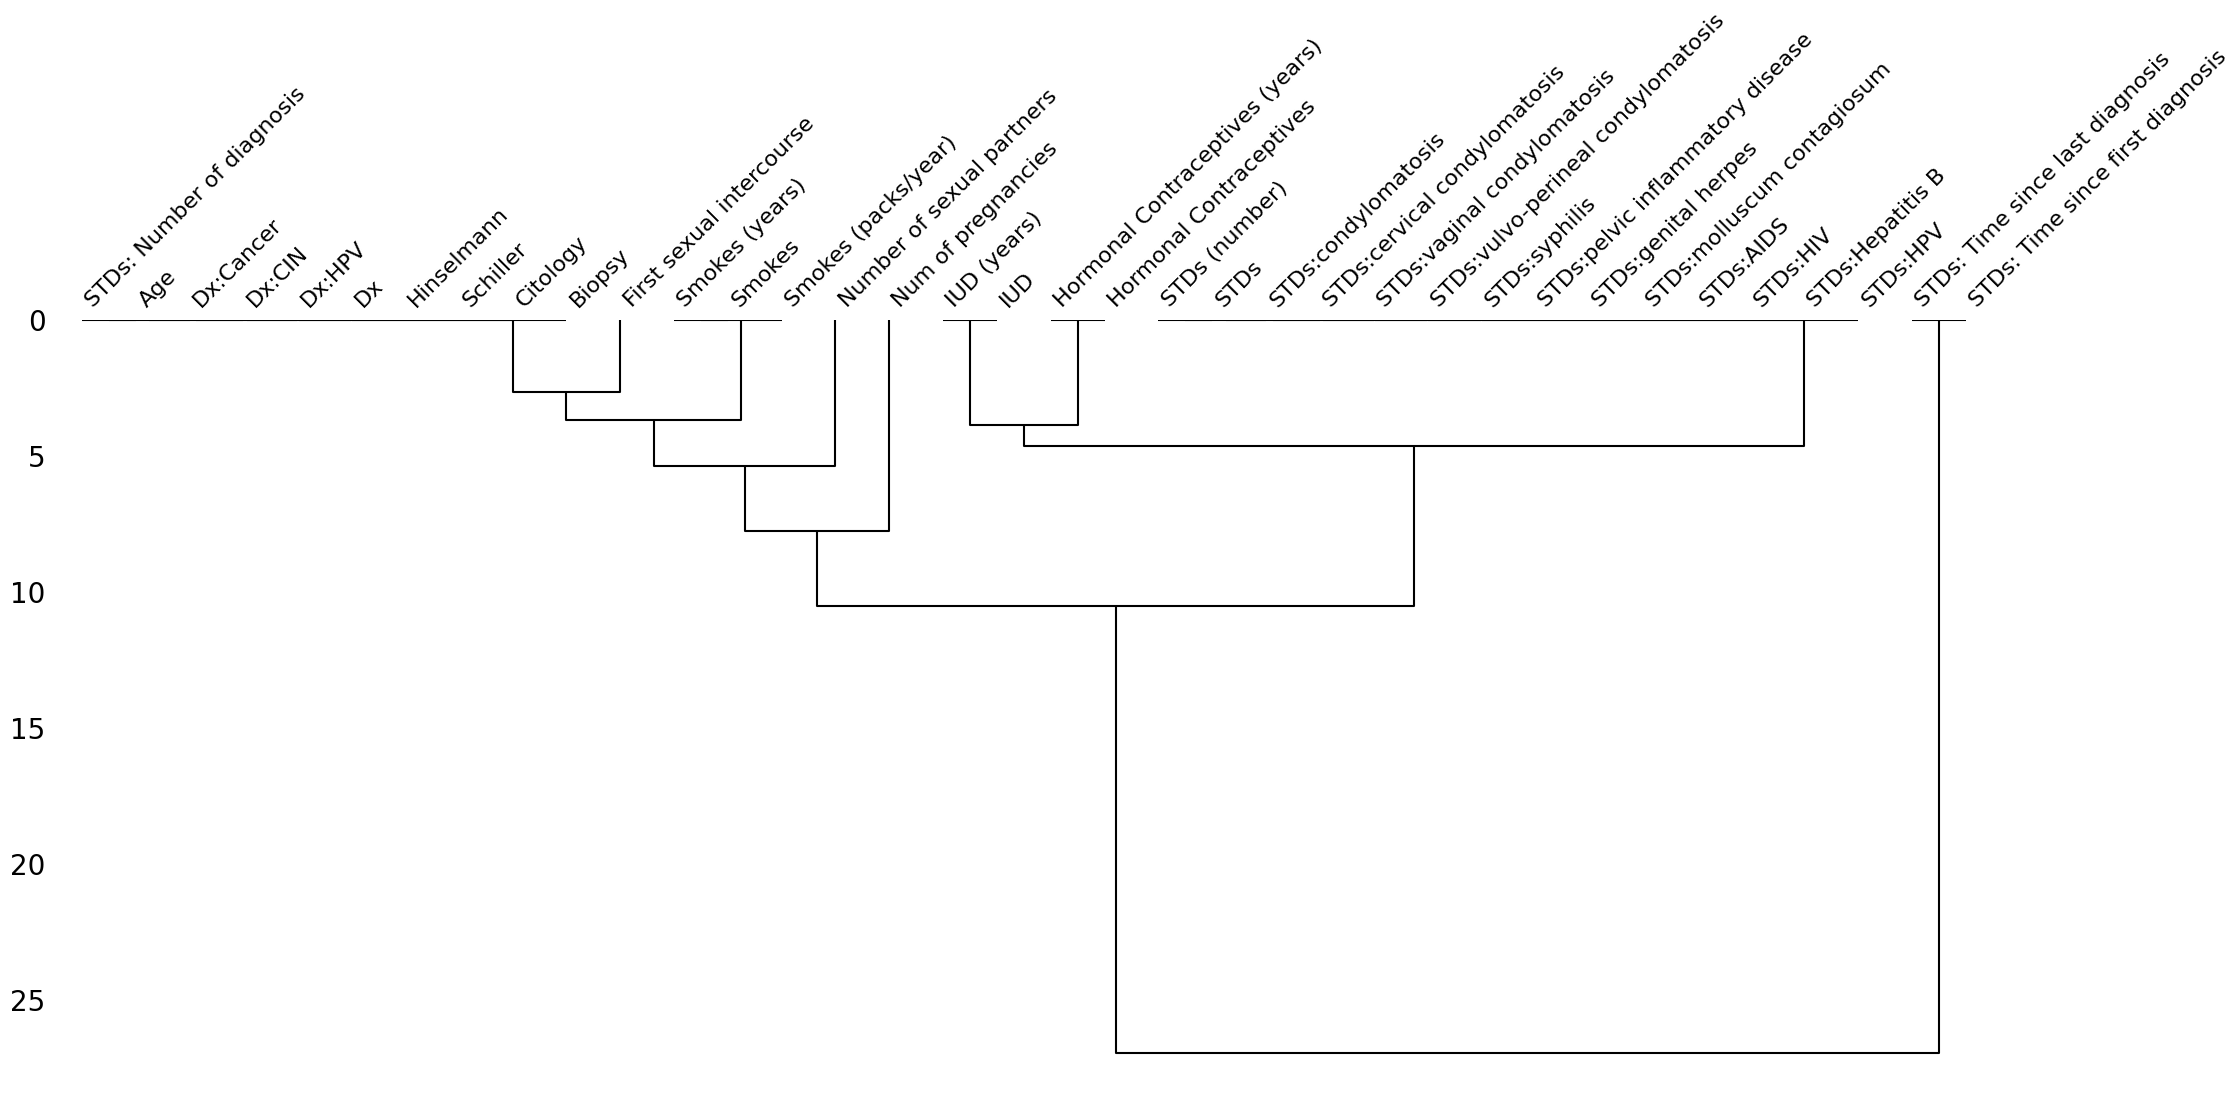

In [11]:
msno.dendrogram(df_RFCC)


Dados los requerimientos del experto, en el cual se pide que se incluyan todas las variables, así estas no aporten información relevante, para dar manejo a los valores faltantes, será necesario aplicar técnicas de imputación de datos. Para ello, se evaluará el rendimiento de diferentes técnicas de imputación para evaluar la precisión de estos nuevos datos y poner a generar un modelo de mayor precisión.

### Análisis exploratorio de características

Nos centraremos por el momento en las variables con valores faltantes. Para ello, se graficará la distribución y un diagrama de caja para poder observar sus cuartiles, mediana, distribución y valores atípicos.

In [12]:
columns_with_MV = (df_RFCC.isna().sum()[df_RFCC.isna().sum() != 0]).index.tolist()
columns_with_MV

['Number of sexual partners',
 'First sexual intercourse',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:cervical condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:AIDS',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV',
 'STDs: Time since first diagnosis',
 'STDs: Time since last diagnosis']

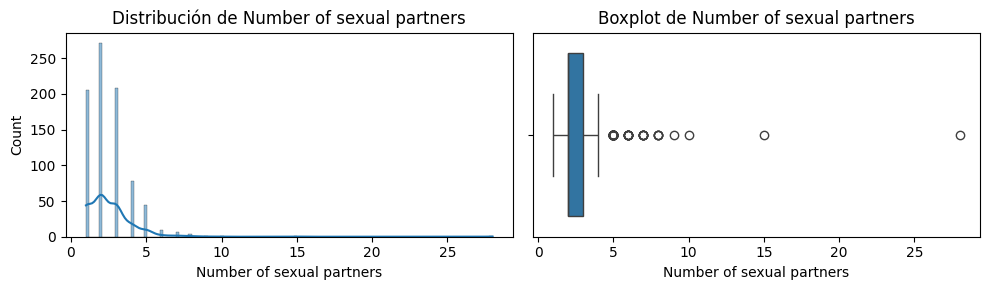

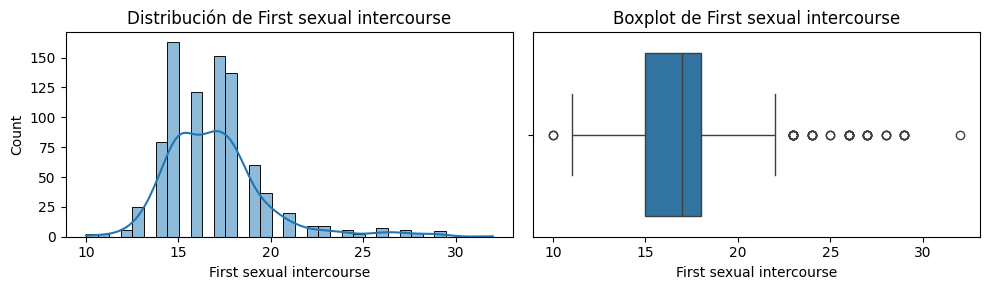

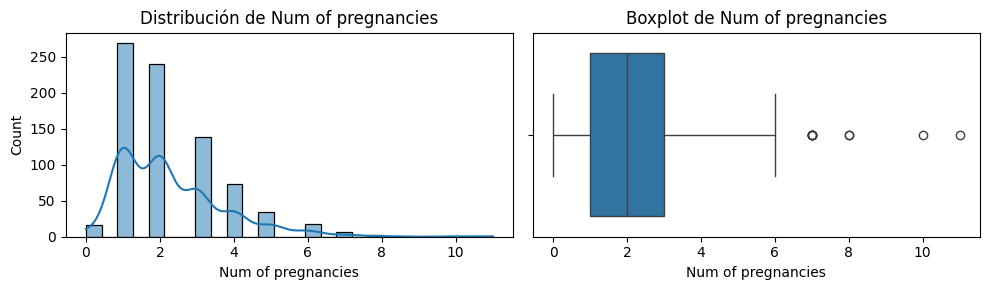

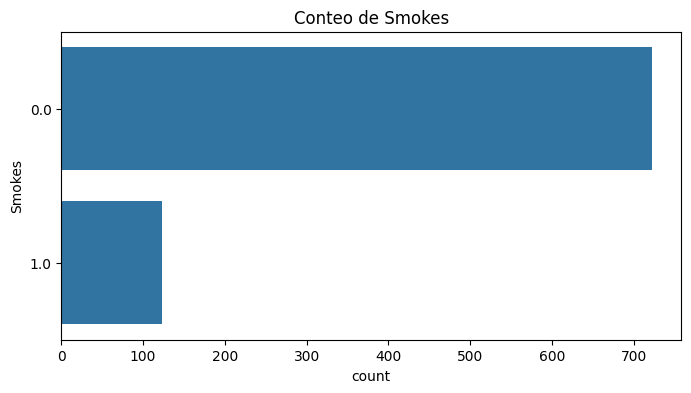

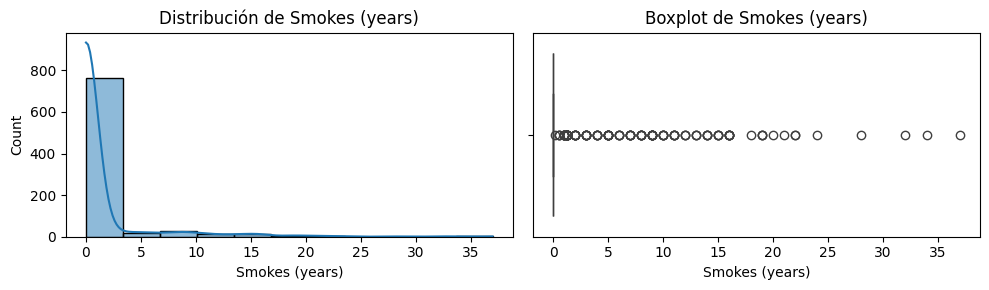

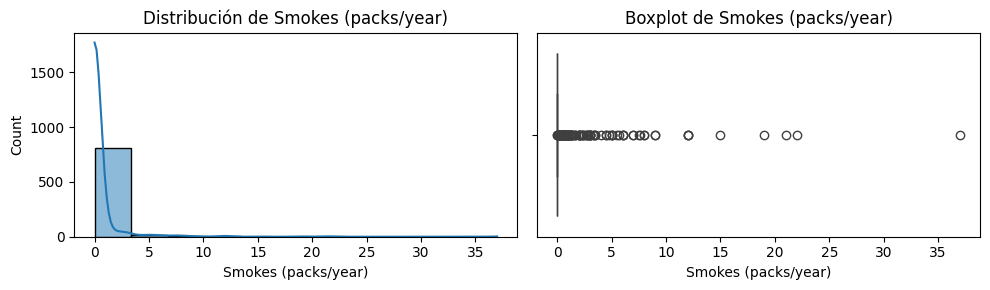

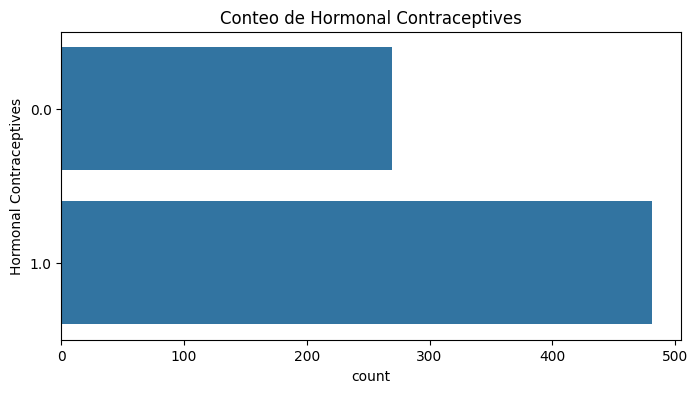

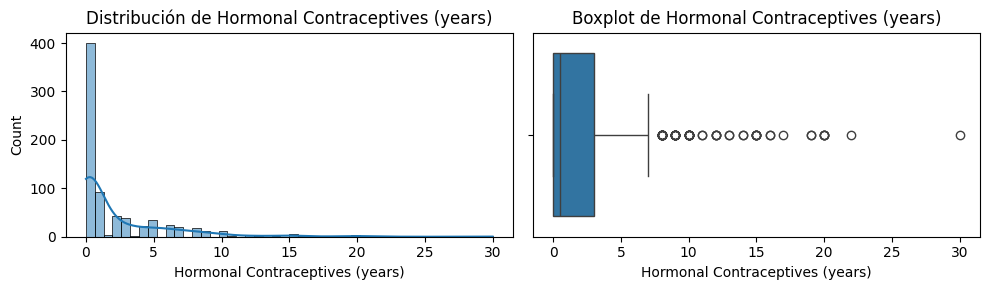

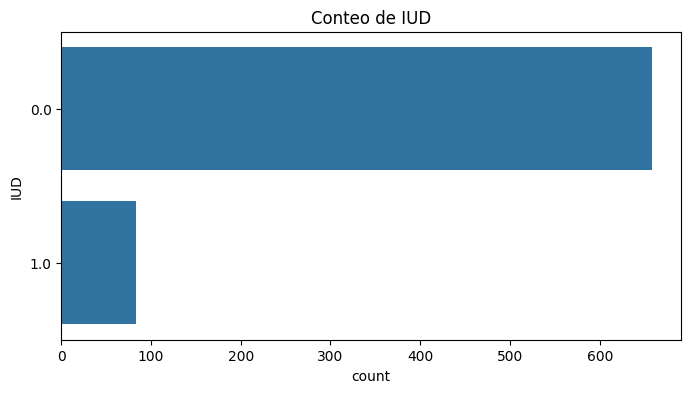

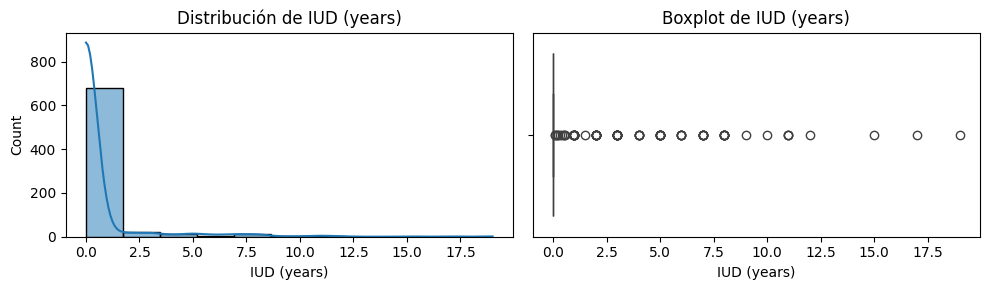

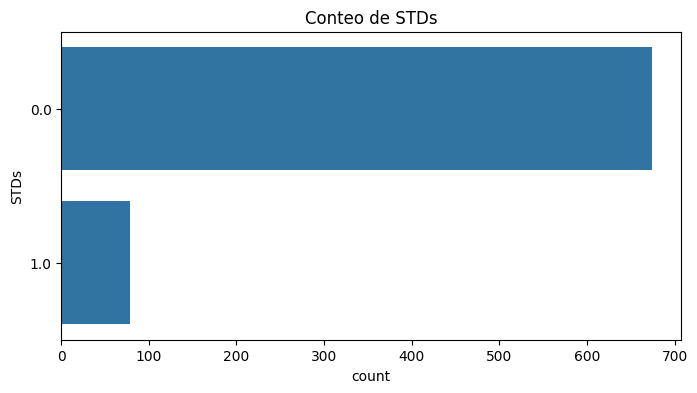

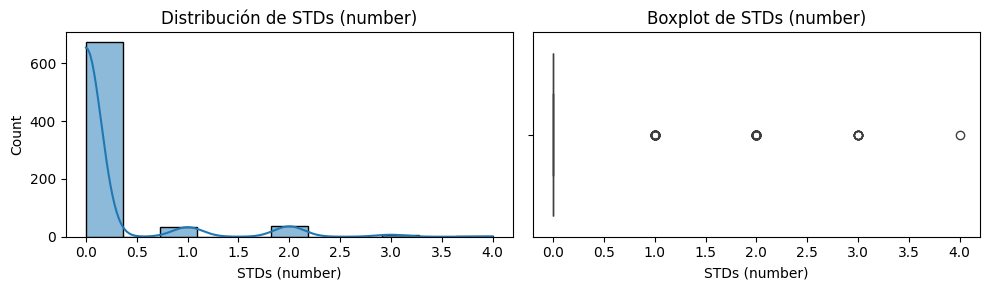

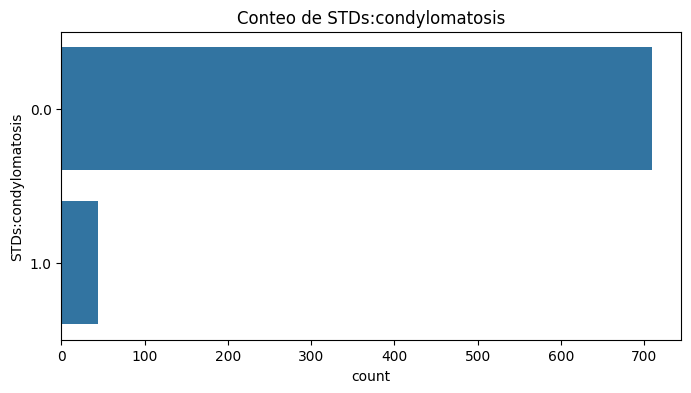

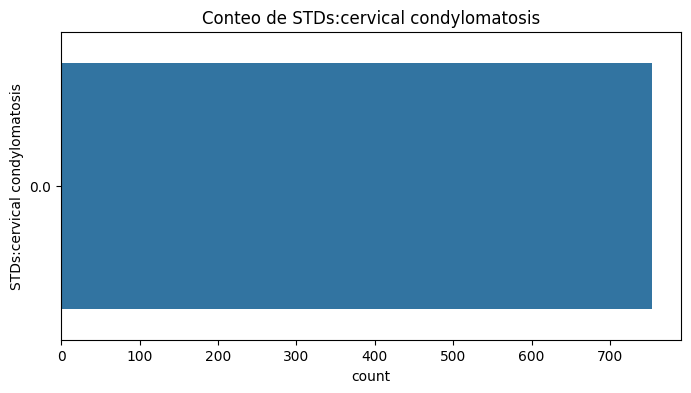

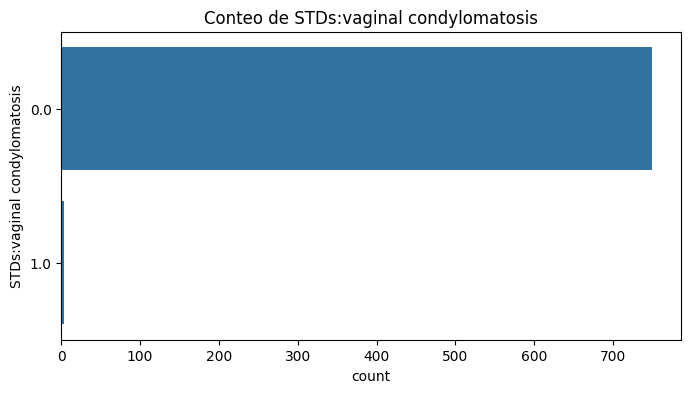

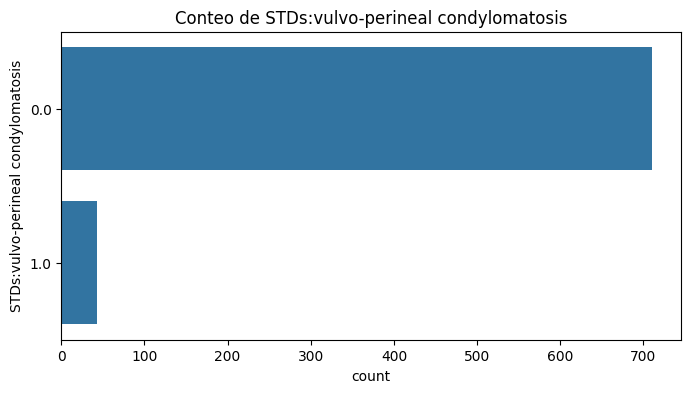

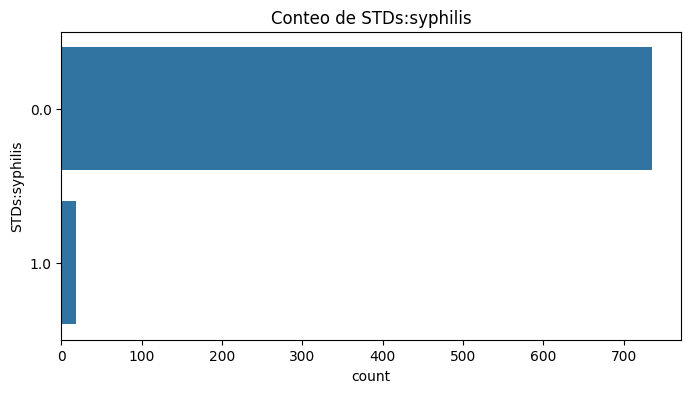

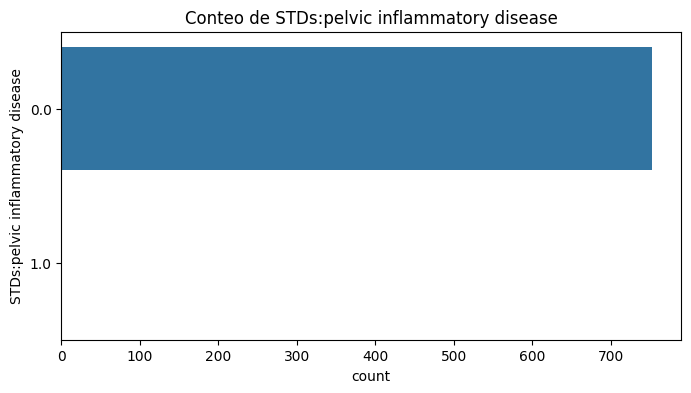

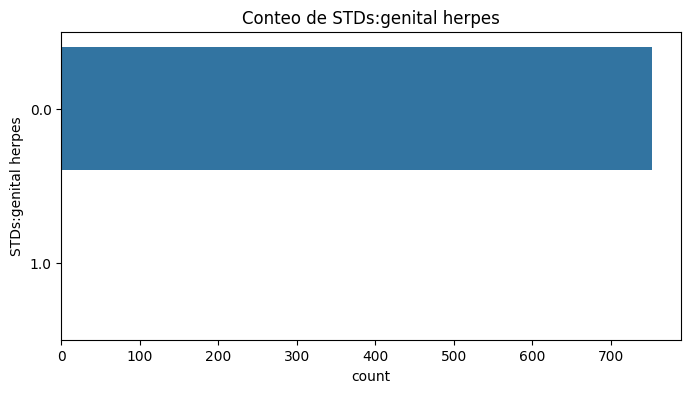

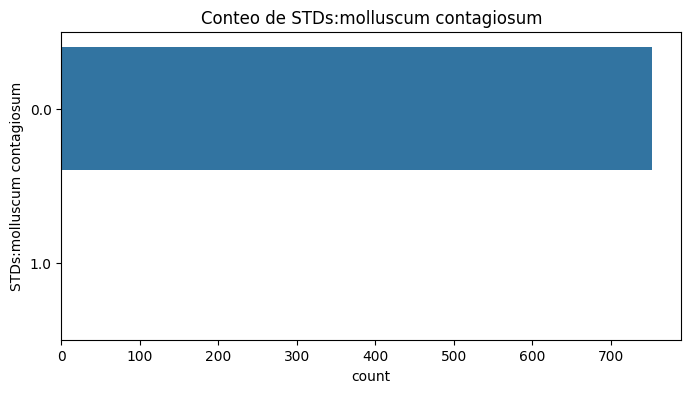

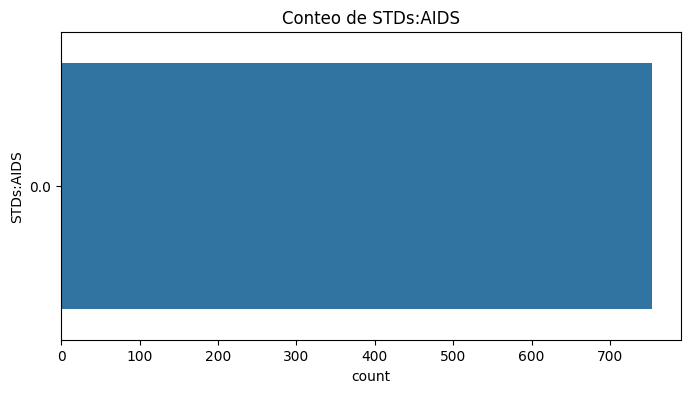

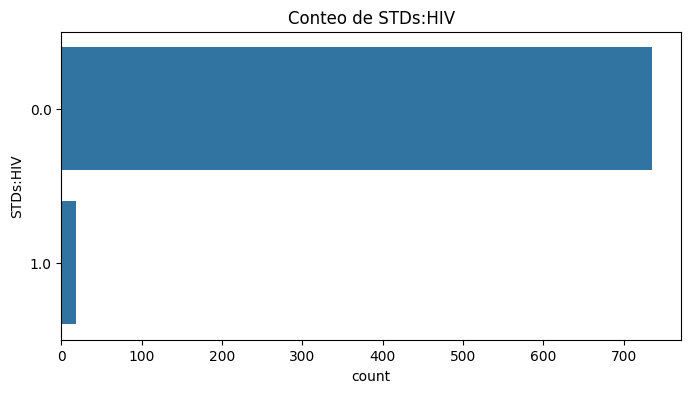

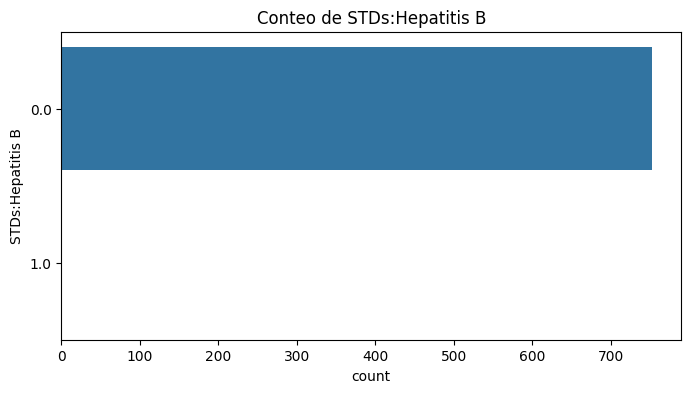

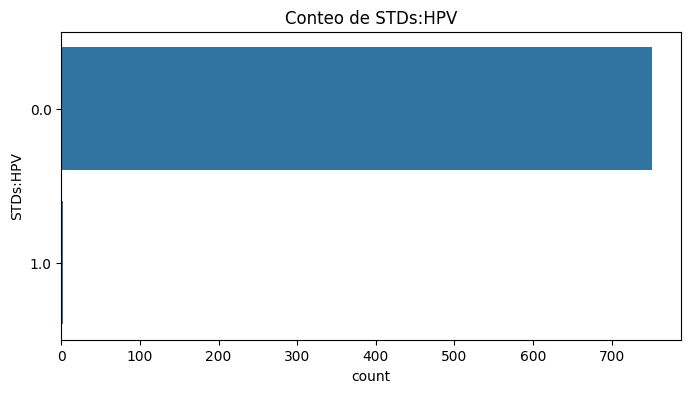

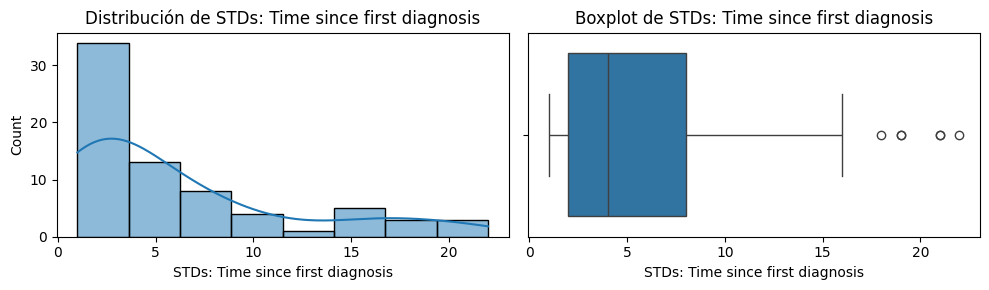

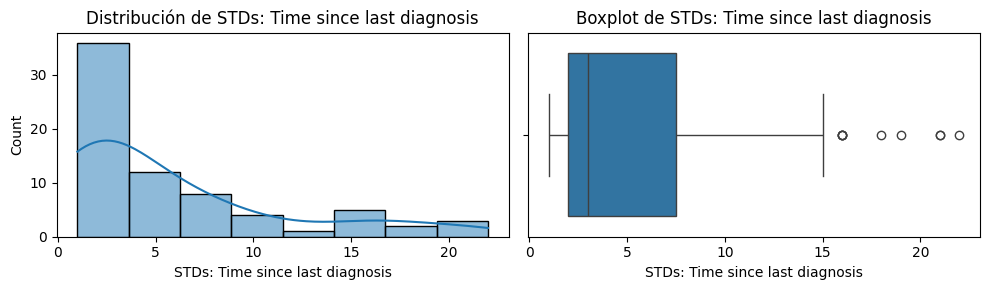

In [13]:
def is_binary_categorical(series):
    # Get unique values in the series
    unique_values = series.dropna().unique()
    # Check if all unique values are either 0 or 1
    return set(unique_values).issubset({0, 1})


categorical_columns = []
numeric_columns = []

for column in df_RFCC.select_dtypes(include=[np.number]).columns:
    if column in columns_with_MV:
        if not is_binary_categorical(df_RFCC[column]):
            numeric_columns.append(column)
            # Gráfico de histograma para variables numéricas
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
            sns.histplot(df_RFCC[column], kde=True, ax=axes[0])
            axes[0].set_title(f'Distribución de {column}')
            # Gráfico de caja para variables numéricas
            sns.boxplot(x=df_RFCC[column], ax=axes[1])
            axes[1].set_title(f'Boxplot de {column}')
            plt.tight_layout()
            plt.show()
        else:
            categorical_columns.append(column)
            # Gráfico de barras para variables categóricas binarias
            plt.figure(figsize=(8, 4))
            sns.countplot(y=df_RFCC[column])
            plt.title(f'Conteo de {column}')
            plt.show()

### Imputacion de datos

#### Variables categóricas
Observamos ahora únicamente la correlación entre las variables categóricas.

<Axes: >

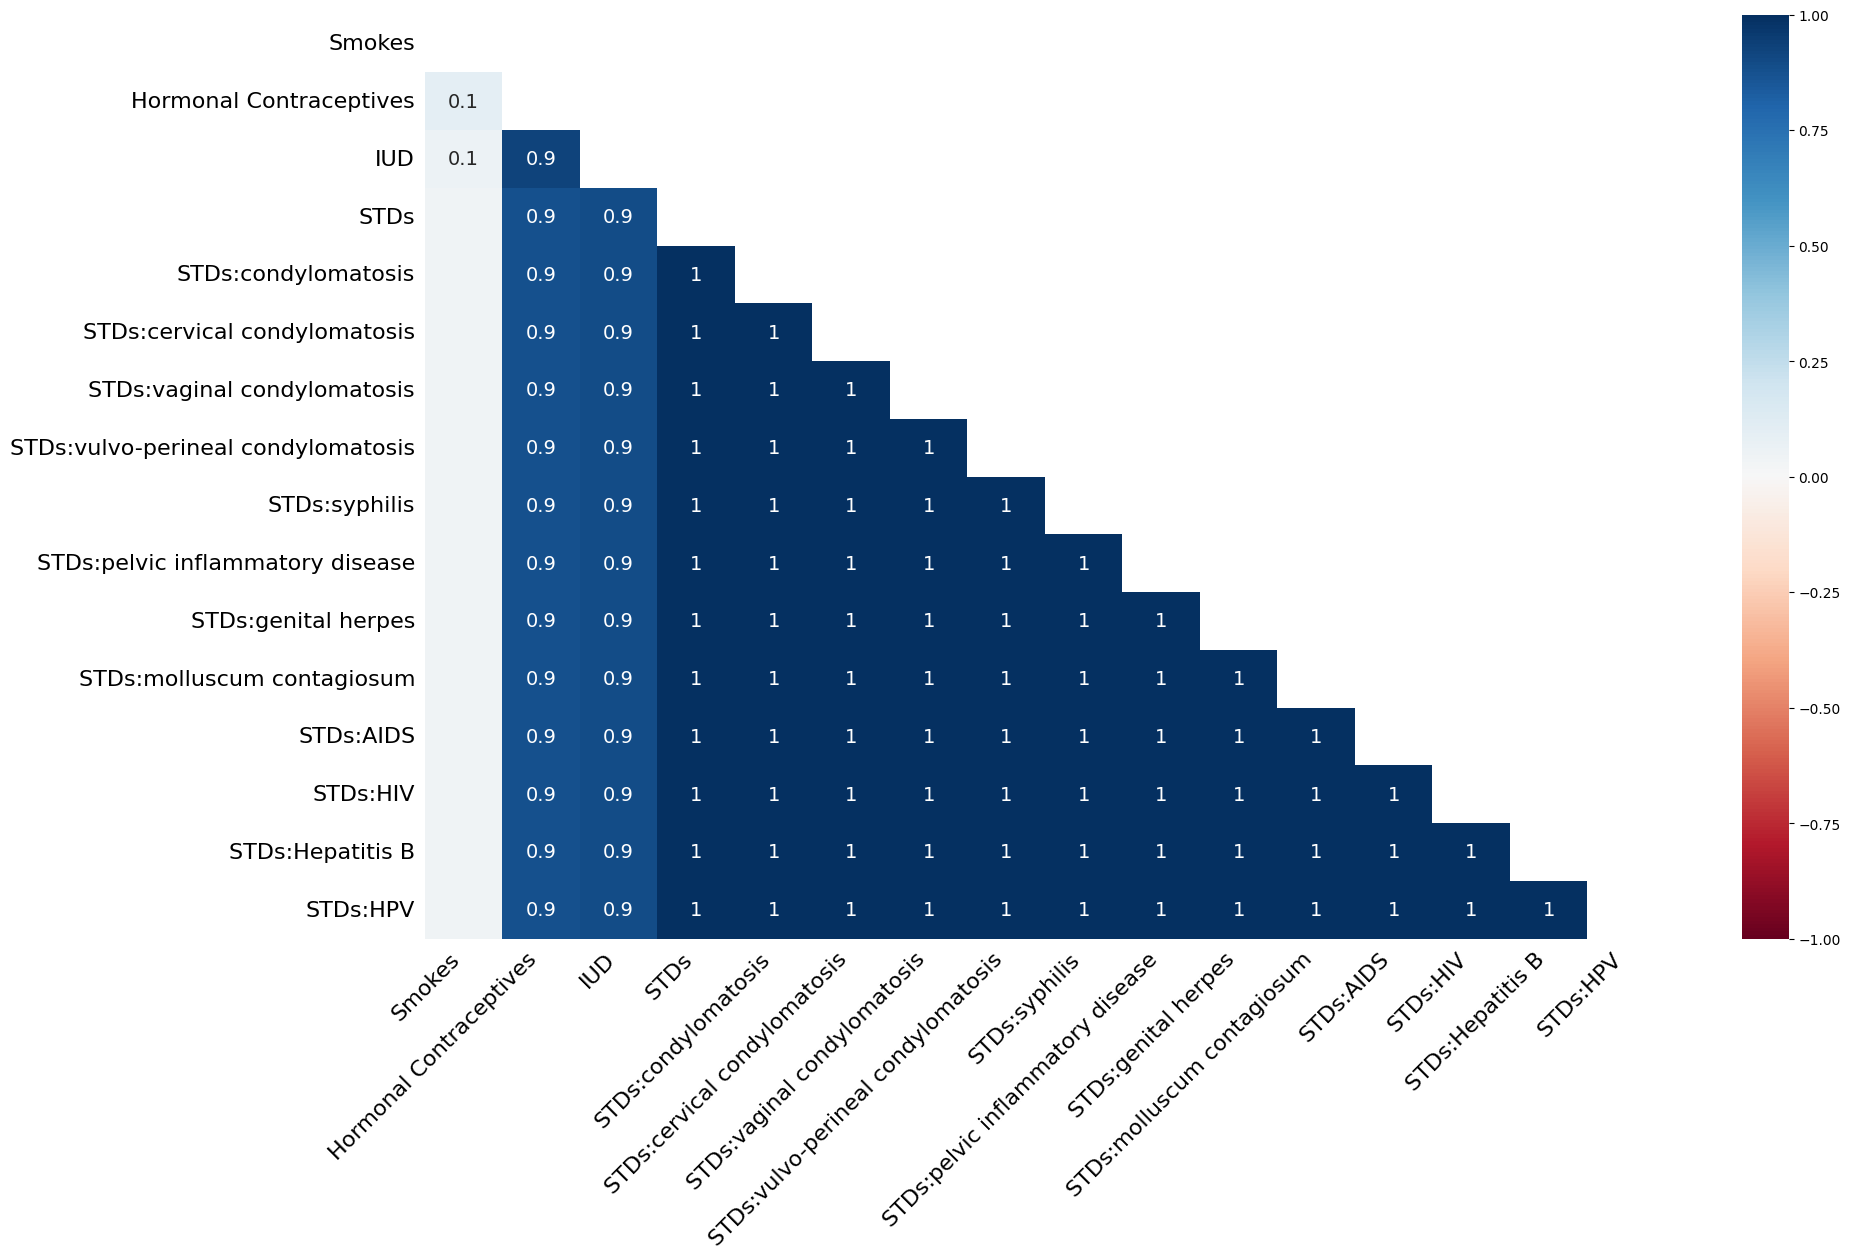

In [14]:
cor_matrix_categorical = df_RFCC[categorical_columns].corr()

# Visualize the correlation of missing values
msno.heatmap(df_RFCC[categorical_columns])

Dado que la variable *Smokes* no se relaciona con alguna otra y suponemos que la falta de información es de tipo MAR dado el análisis previo, podemos imputar datos bajo probabilidad, de esta manera, se sigue la distribución de los datos sin generar una alteracion en la estructura de los datos faltantes.

In [15]:
# Function to impute values based on probability
def probabilistic_imputation(series, prob):
    return series.apply(lambda x: np.random.choice([0, 1], p=[1-prob, prob]) if pd.isna(x) else x)

df_RFCC_imputed = df_RFCC.copy()

prob_smokes = df_RFCC['Smokes'].mean()
df_RFCC_imputed['Smokes'] = probabilistic_imputation(df_RFCC['Smokes'], prob_smokes)

categorical_columns.remove('Smokes')


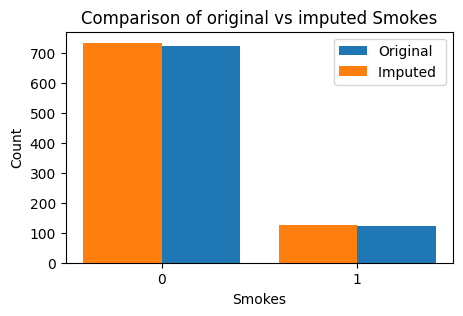


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148


In [16]:
smoke_imputed = df_RFCC_imputed['Smokes'].value_counts()
smoke = df_RFCC['Smokes'].value_counts()

def compare_cate_variable(original_series, imputed_series, col_name):
    plt.figure(figsize=(5, 3))
    figure1 = plt.bar(range(len(original_series)), original_series, align='edge', width=0.4, label='Original')
    figure2 = plt.bar(range(len(imputed_series)), imputed_series, align='edge', width=-0.4, label='Imputed ')
    plt.legend()
    plt.xticks(np.arange(len(smoke)), rotation=0)
    plt.title(f"Comparison of original vs imputed {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.show()
    print(f"\nImputed series  -> std: {df_RFCC_imputed['Smokes'].std()}, mean: {df_RFCC_imputed['Smokes'].mean()}")
    print(f"Original series -> std: {df_RFCC['Smokes'].std()}, mean: {df_RFCC['Smokes'].mean()}")

compare_cate_variable(smoke, smoke_imputed, 'Smokes')

Podemos observar de esta manera que se sigue la misma distribución de datos para la variable *Smokes*.

Ahora, para las demás variables categóricas, dada su correlación en los valores faltantes, se aplicará el algoritmo de K Nearest Neighbors, donde la idea es buscar las K muestras más cercanas en el dataset, luego se toma el valor del descriptor que ocurre con mayor frecuencia en dicha vecindad, como reemplazo del valor perdido. Se escogió este método dado que ofrece mayor robustez para capturar patrones complejos en los datos y permite una fácil aplicación para las variables categóricas sin perder su distribución.

Alternativamente, también se pueden imputar los datos para este caso haciendo uso del método *most_frequent* con el cual también se logran buenos resultados con un costo computacional menor. Sin embargo, se prefiere hacer uso de KNN debido a que otorga mayor robustez.

Para ello, primero se busca determinar el número de vecinos usando validación cruzada (cross-validation).

In [17]:
# Find the optimal number of neighbors using cross-validation
def find_optimal_k(X, y):
    k_range = range(1, 21)
    scores = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        mse_scores = -cross_val_score(knn, X, y, scoring='neg_mean_squared_error')
        scores.append(mse_scores.mean())
    optimal_k = k_range[scores.index(min(scores))]
    return optimal_k

# Prepare data for cross-validation
X = df_RFCC_imputed.dropna().drop(df_RFCC_imputed.columns[-1], axis=1)
y = df_RFCC_imputed.dropna()[df_RFCC_imputed.columns[-1]]

optimal_k = find_optimal_k(X, y)
print(f'Optimal number of neighbors: {optimal_k}')


Optimal number of neighbors: 9


In [18]:
# Create and apply the KNN imputer
imputer_KNN = KNNImputer(n_neighbors=optimal_k)
imputed_data_cat = imputer_KNN.fit_transform(df_RFCC[categorical_columns])

# Create and apply the most?frequent strategy
# imputer_freq = SimpleImputer(strategy='most_frequent')
# imputed_data_freq = imputer_freq.fit_transform(df_RFCC[categorical_columns])

# Standardize possible values different from 0 or 1
threshold = 0.5
imputed_data_cat = np.where(imputed_data_cat > threshold, 1, 0)

df_RFCC_imputed[categorical_columns] = imputed_data_cat

Hormonal Contraceptives [0 1]


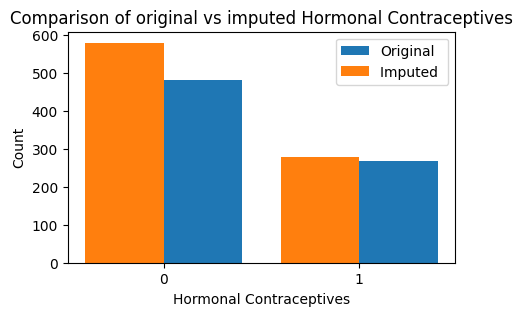


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
IUD [0 1]


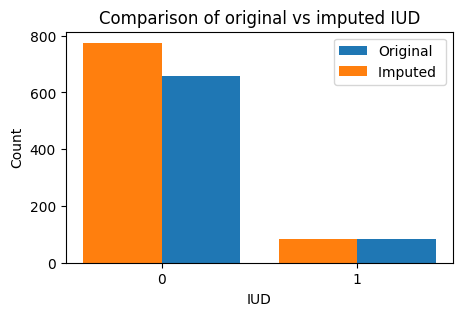


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs [0 1]


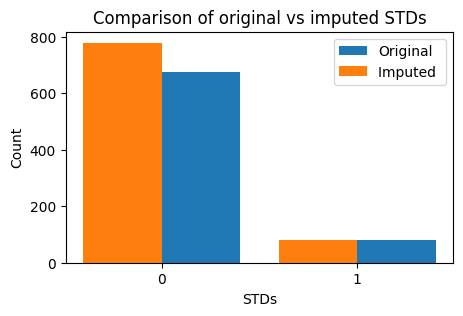


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:condylomatosis [0 1]


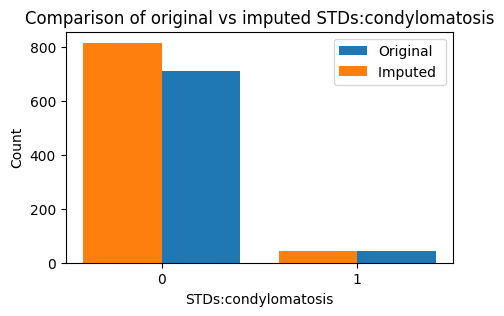


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:cervical condylomatosis [0 1]


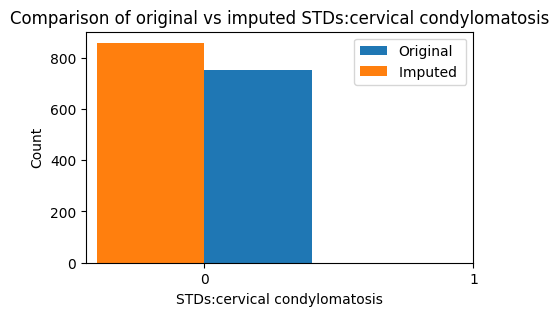


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:vaginal condylomatosis [0 1]


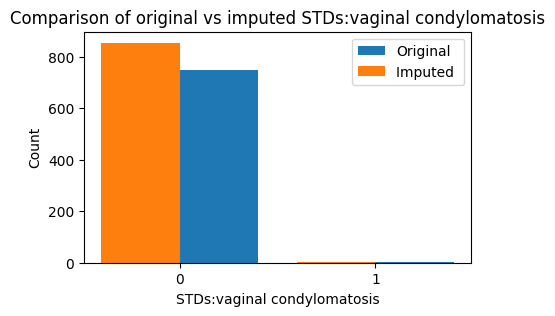


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:vulvo-perineal condylomatosis [0 1]


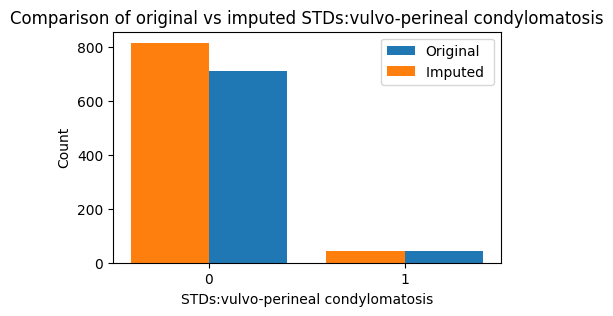


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:syphilis [0 1]


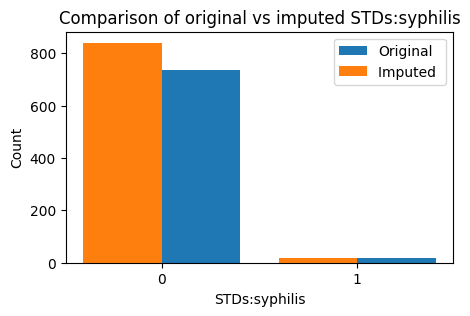


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:pelvic inflammatory disease [0 1]


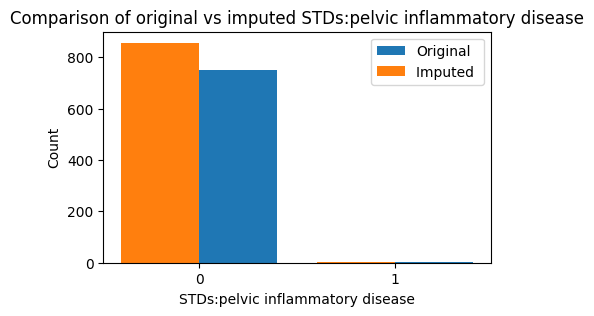


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:genital herpes [0 1]


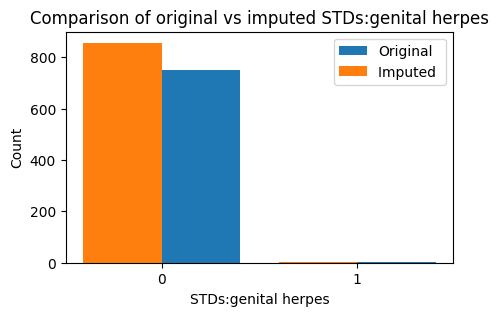


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:molluscum contagiosum [0 1]


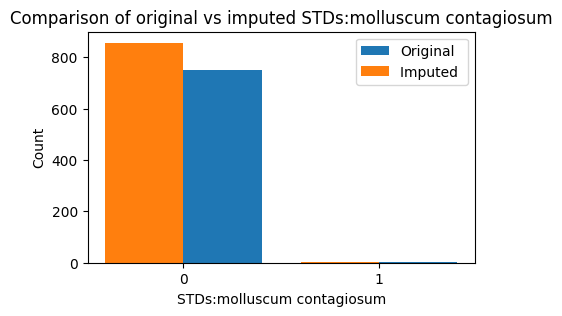


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:AIDS [0 1]


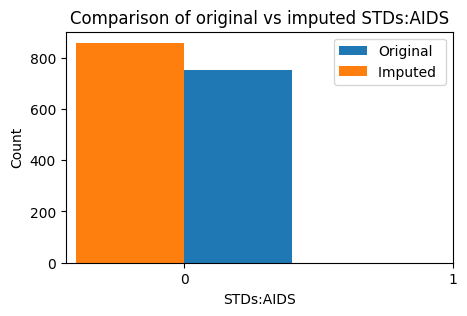


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:HIV [0 1]


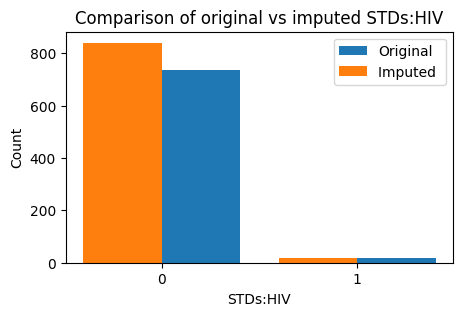


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:Hepatitis B [0 1]


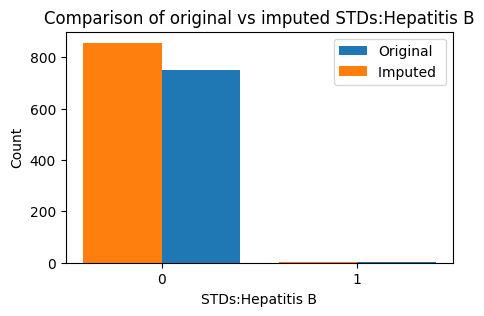


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148
STDs:HPV [0 1]


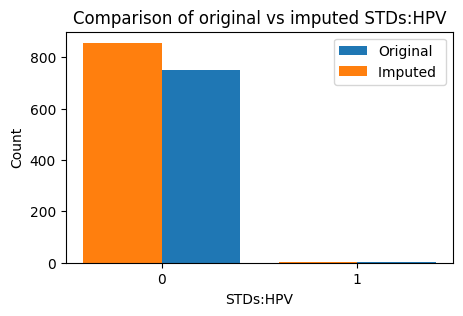


Imputed series  -> std: 0.3529985642108773, mean: 0.1456876456876457
Original series -> std: 0.3528755570364017, mean: 0.1455621301775148


In [19]:
for col in categorical_columns:
    print(col, df_RFCC_imputed[categorical_columns[5]].unique())
    compare_cate_variable(df_RFCC[col].value_counts(), df_RFCC_imputed[col].value_counts(), col)

Podemos observar que, en esencia, la distribución de los datos no ha cambiado posterior a la imputación de datos.

#### Variables numéricas

Dado el supuesto estipulado sobre la falta de información a partir del análisis previamente realizado, donde se tiene que la falta de información es de tipo MNAR, se realizará una imputación "múltiple" donde luego se evaluara su rendimiento mediante la prueba de Kolmogorov-Smirnov, la cual determina la bondad de ajuste entre dos distribuciones. primero, se validan los valores existentes en las columnas

In [20]:
for column in numeric_columns:
    print(column, df_RFCC[column].unique())

Number of sexual partners [ 4.  1.  5.  3.  2.  6. nan  7. 15.  8. 10. 28.  9.]
First sexual intercourse [15. 14. nan 16. 21. 23. 17. 26. 20. 25. 18. 27. 19. 24. 32. 13. 29. 11.
 12. 22. 28. 10.]
Num of pregnancies [ 1.  4.  2.  6.  3.  5. nan  8.  7.  0. 11. 10.]
Smokes (years) [ 0.         37.         34.          1.26697291  3.         12.
         nan 18.          7.         19.         21.         15.
 13.         16.          8.          4.         10.         22.
 14.          0.5        11.          9.          2.          5.
  6.          1.         32.         24.         28.         20.
  0.16      ]
Smokes (packs/year) [0.00000000e+00 3.70000000e+01 3.40000000e+00 2.80000000e+00
 4.00000000e-02 5.13202128e-01 2.40000000e+00 6.00000000e+00
            nan 9.00000000e+00 1.60000000e+00 1.90000000e+01
 2.10000000e+01 3.20000000e-01 2.60000000e+00 8.00000000e-01
 1.50000000e+01 2.00000000e+00 5.70000000e+00 1.00000000e+00
 3.30000000e+00 3.50000000e+00 1.20000000e+01 2.50000000

Podemos observar que algunas variables consideran valores decimales. Razón por la cual, se buscará estandarizar la imputación de datos a valores enteros para las demás características.

In [21]:
col_with_decimal = []
col_without_decimal = []
for col in numeric_columns:
    # Use modf to split the decimal and integer parts
    fractional_parts, _ = np.modf(df_RFCC[col].dropna())
    if (fractional_parts != 0).any():
        col_with_decimal.append(col)
    else:
        col_without_decimal.append(col)

print(f"Columns with decimal values: {col_with_decimal}")
print(f"Columns without decimal values: {col_without_decimal}")

Columns with decimal values: ['Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)']
Columns without decimal values: ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'STDs (number)', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis']


En búsqueda de obtener mejores resultados en la imputación de datos, se aplican técnicas diferentes para las características que cuentan con valores decimales y las que cuentan con valores enteros. Para las características con valores decimales se aplicará un proceso de imputación múltiple utilizando como estimador inicial la media. Para el caso de los valores enteros, se utiliza el mismo procedimiento, pero haciendo uso de los vecinos más cercanos, tomando como número de vecinos los previamente definidos para el caso de las variables categoricas y con ello tener mayor consistencia en la imputación de datos.

In [22]:
# Imputer for numerical columns
iterative_imputer = IterativeImputer(random_state=0)
iterative_imputer_KNN = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=optimal_k), random_state=0)

imputed_data_dec = iterative_imputer.fit_transform(df_RFCC[col_with_decimal])
imputed_data_num = iterative_imputer_KNN.fit_transform(df_RFCC[col_without_decimal])

df_RFCC_imputed[col_with_decimal] = imputed_data_dec
df_RFCC_imputed[col_without_decimal] = imputed_data_num

df_RFCC_imputed.head()

C:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Age  Number of sexual partners  First sexual intercourse  \
0   18                        4.0                 15.000000   
1   15                        1.0                 14.000000   
2   34                        1.0                 14.777778   
3   52                        5.0                 16.000000   
4   46                        3.0                 21.000000   

   Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                 1.0     0.0             0.0                  0.0   
1                 1.0     0.0             0.0                  0.0   
2                 1.0     0.0             0.0                  0.0   
3                 4.0     1.0            37.0                 37.0   
4                 4.0     0.0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (years)  IUD  ...  \
0                        0                              0.0    0  ...   
1                        0                              0.0    0  ...   
2                        0                              0.0    0  ...   
3                        1                              3.0    0  ...   
4                        1                             15.0    0  ...   

   STDs: Time since first diagnosis  STDs: Time since last diagnosis  \
0                          1.666667                         1.666667   
1                          1.555556                         1.555556   
2                          1.555556                         1.555556   
3                          2.333333                         2.333333   
4                          5.666667                         5.666667   

   Dx:Cancer  Dx:CIN  Dx:HPV  Dx  Hinselmann  Schiller  Citology  Biopsy  
0          0       0       0   0           0         0         0       0  
1          0       0       0   0           0         0         0       0  
2          0       0       0   0           0         0         0       0  
3          1       0       1   0           0         0         0       0  
4          0       0       0   0           0         0         0       0  

[5 rows x 36 columns]


Imputed series  -> std: 1.6471528114452583, mean: 2.527972027972028
Original series -> std: 1.6677604771839054, mean: 2.527644230769231
KS Statistic: 0.011582167832167832
P-value: 0.999999978401548
Las distribuciones son similares.


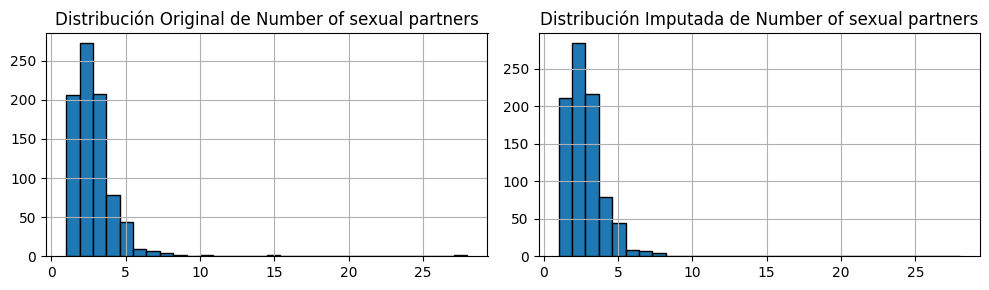


Imputed series  -> std: 2.795899358187148, mean: 16.9970214970215
Original series -> std: 2.8033553841969017, mean: 16.995299647473562
KS Statistic: 0.0017667408971756798
P-value: 1.0
Las distribuciones son similares.


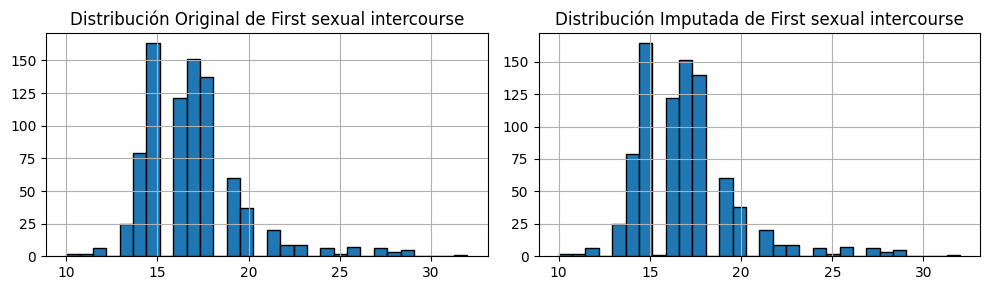


Imputed series  -> std: 1.4229902959208893, mean: 2.2852887852887855
Original series -> std: 1.4474140691327373, mean: 2.275561097256858
KS Statistic: 0.01744763964215336
P-value: 0.9993138722604842
Las distribuciones son similares.


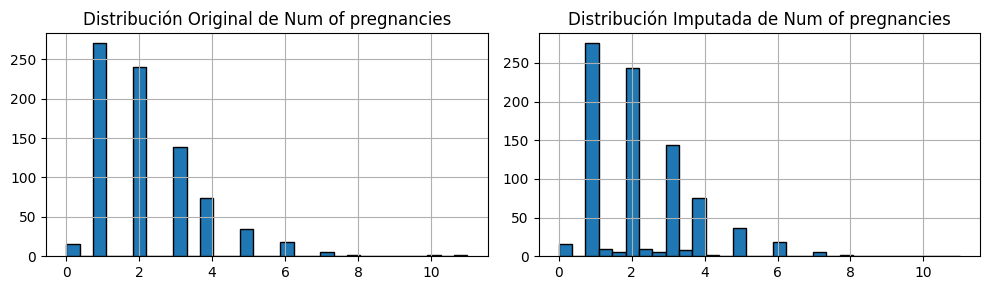


Imputed series  -> std: 4.0579450708072455, mean: 1.2196106910186064
Original series -> std: 4.089016937562997, mean: 1.219721412585799
KS Statistic: 0.013161197776582392
P-value: 0.9999983181487289
Las distribuciones son similares.


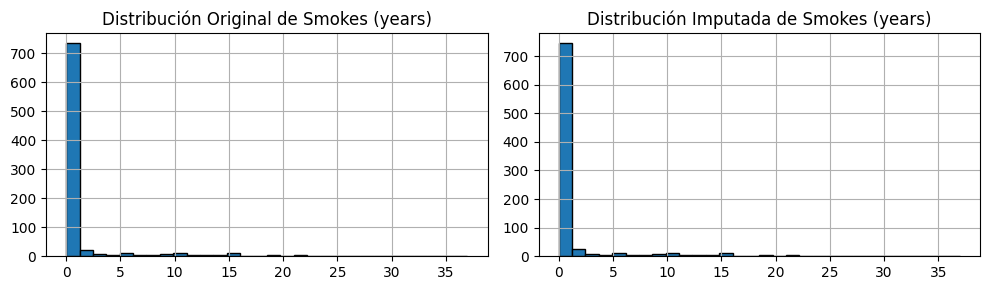


Imputed series  -> std: 2.209667923046732, mean: 0.45301990183171026
Original series -> std: 2.2266098026053953, mean: 0.4531439506492308
KS Statistic: 0.013358436435359512
P-value: 0.9999974197514019
Las distribuciones son similares.


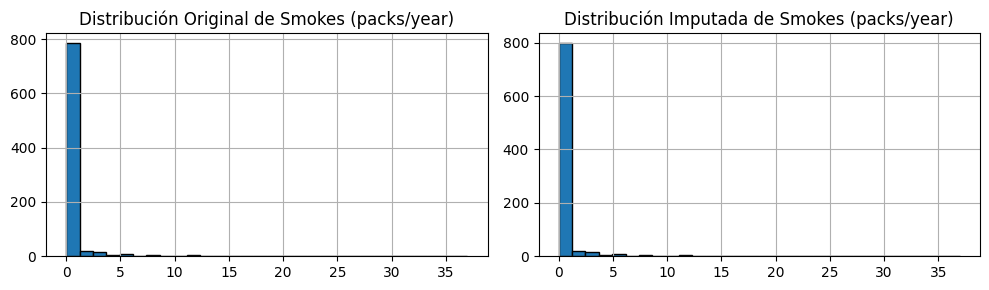


Imputed series  -> std: 3.5191201681020687, mean: 2.256039431601286
Original series -> std: 3.7642535291465054, mean: 2.2564192013893334
KS Statistic: 0.08995804195804195
P-value: 0.0028285024078492224
Las distribuciones son significativamente diferentes.


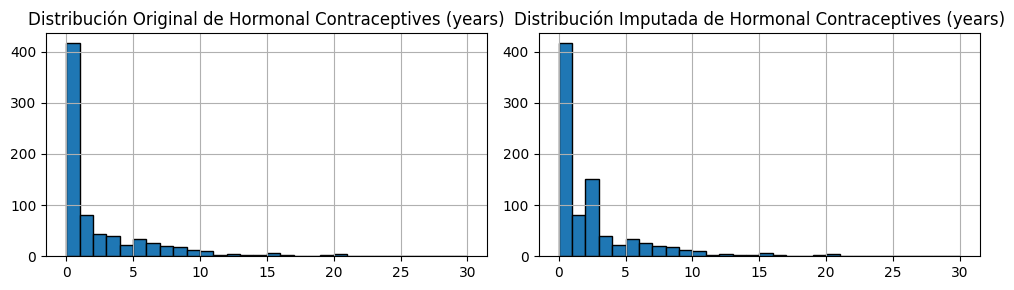


Imputed series  -> std: 1.8055867363061073, mean: 0.514781746817705
Original series -> std: 1.9430885475317108, mean: 0.5148043184885289
KS Statistic: 0.12274567537725432
P-value: 1.1041950747908773e-05
Las distribuciones son significativamente diferentes.


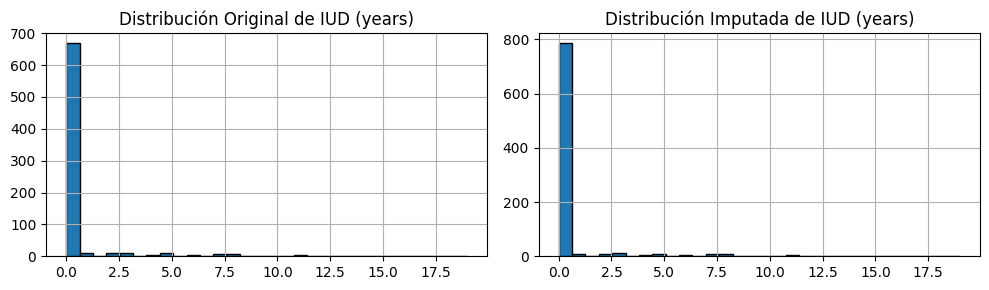


Imputed series  -> std: 0.5294491984976561, mean: 0.1616161616161616
Original series -> std: 0.5619928353566201, mean: 0.17662682602921648
KS Statistic: 0.017463943758764477
P-value: 0.9994786913611756
Las distribuciones son similares.


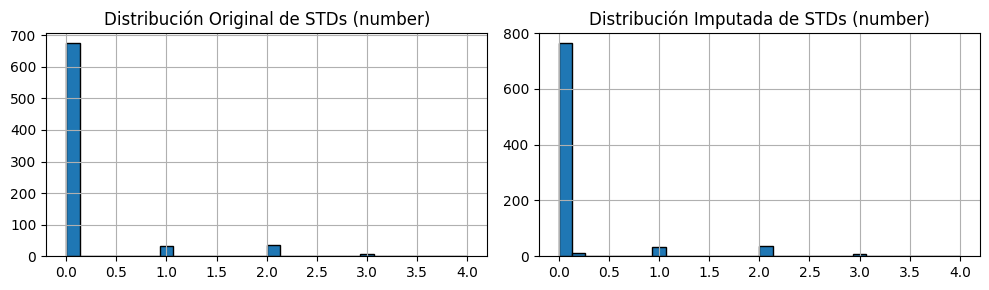


Imputed series  -> std: 2.3616008137470166, mean: 3.2995337995337994
Original series -> std: 5.8950239903737875, mean: 6.140845070422535
KS Statistic: 0.34065465051380545
P-value: 2.747227905660683e-07
Las distribuciones son significativamente diferentes.


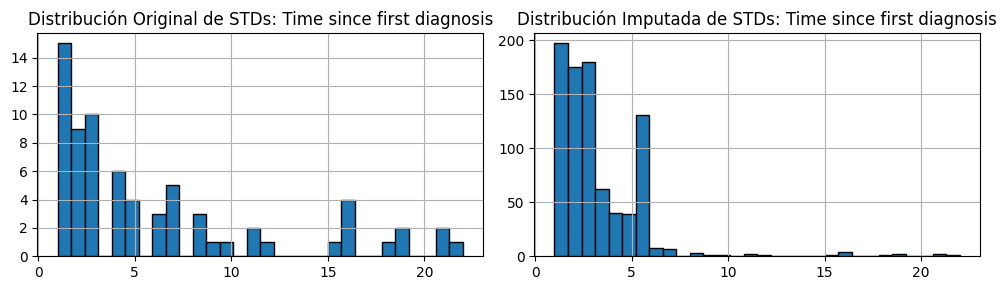


Imputed series  -> std: 2.3014661374572554, mean: 3.272079772079772
Original series -> std: 5.7552705264824855, mean: 5.816901408450704
KS Statistic: 0.32773564463705307
P-value: 9.076156002661434e-07
Las distribuciones son significativamente diferentes.


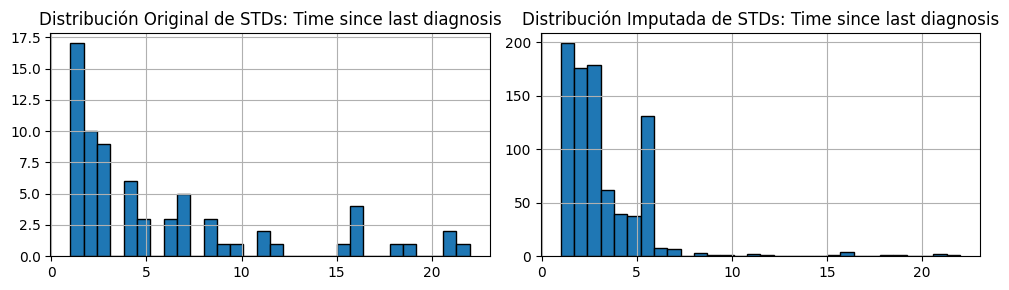

In [23]:
for column in numeric_columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    ks_statistic, p_value = stats.ks_2samp(df_RFCC[column].dropna(), df_RFCC_imputed[column])
    print(f"\nImputed series  -> std: {df_RFCC_imputed[column].std()}, mean: {df_RFCC_imputed[column].mean()}")
    print(f"Original series -> std: {df_RFCC[column].std()}, mean: {df_RFCC[column].mean()}")
    print(f'KS Statistic: {ks_statistic}')
    print(f'P-value: {p_value}')

    if p_value > 0.05:
        print('Las distribuciones son similares.')
    else:
        print('Las distribuciones son significativamente diferentes.')
    df_RFCC[[column]].hist(ax=axes[0], bins=30, edgecolor='black')
    df_RFCC_imputed[[column]].hist(ax=axes[1], bins=30, edgecolor='black')
    axes[0].set_title(f'Distribución Original de {column}')
    axes[1].set_title(f'Distribución Imputada de {column}')
    plt.tight_layout()
    plt.show()

Podemos observar que el rendimiento del imputador de datos es satisfactorio para la mayoría de las características bajo la validación manual y el estadístico KS. Para las variables donde el estadístico no es satisfactorio, podemos observar de igual forma que, validando la media y la desviación estándar, su distribución no varía en una magnitud significativa. Las únicas características que no cumplen con estas dos validaciones son *STDs: Time since last diagnosis* y *STDs: Time since first diagnosis*. Esto se debe a la falta de datos para estas dos columnas, pues, cuentan con un 91% de datos faltantes, según la validación inicial.

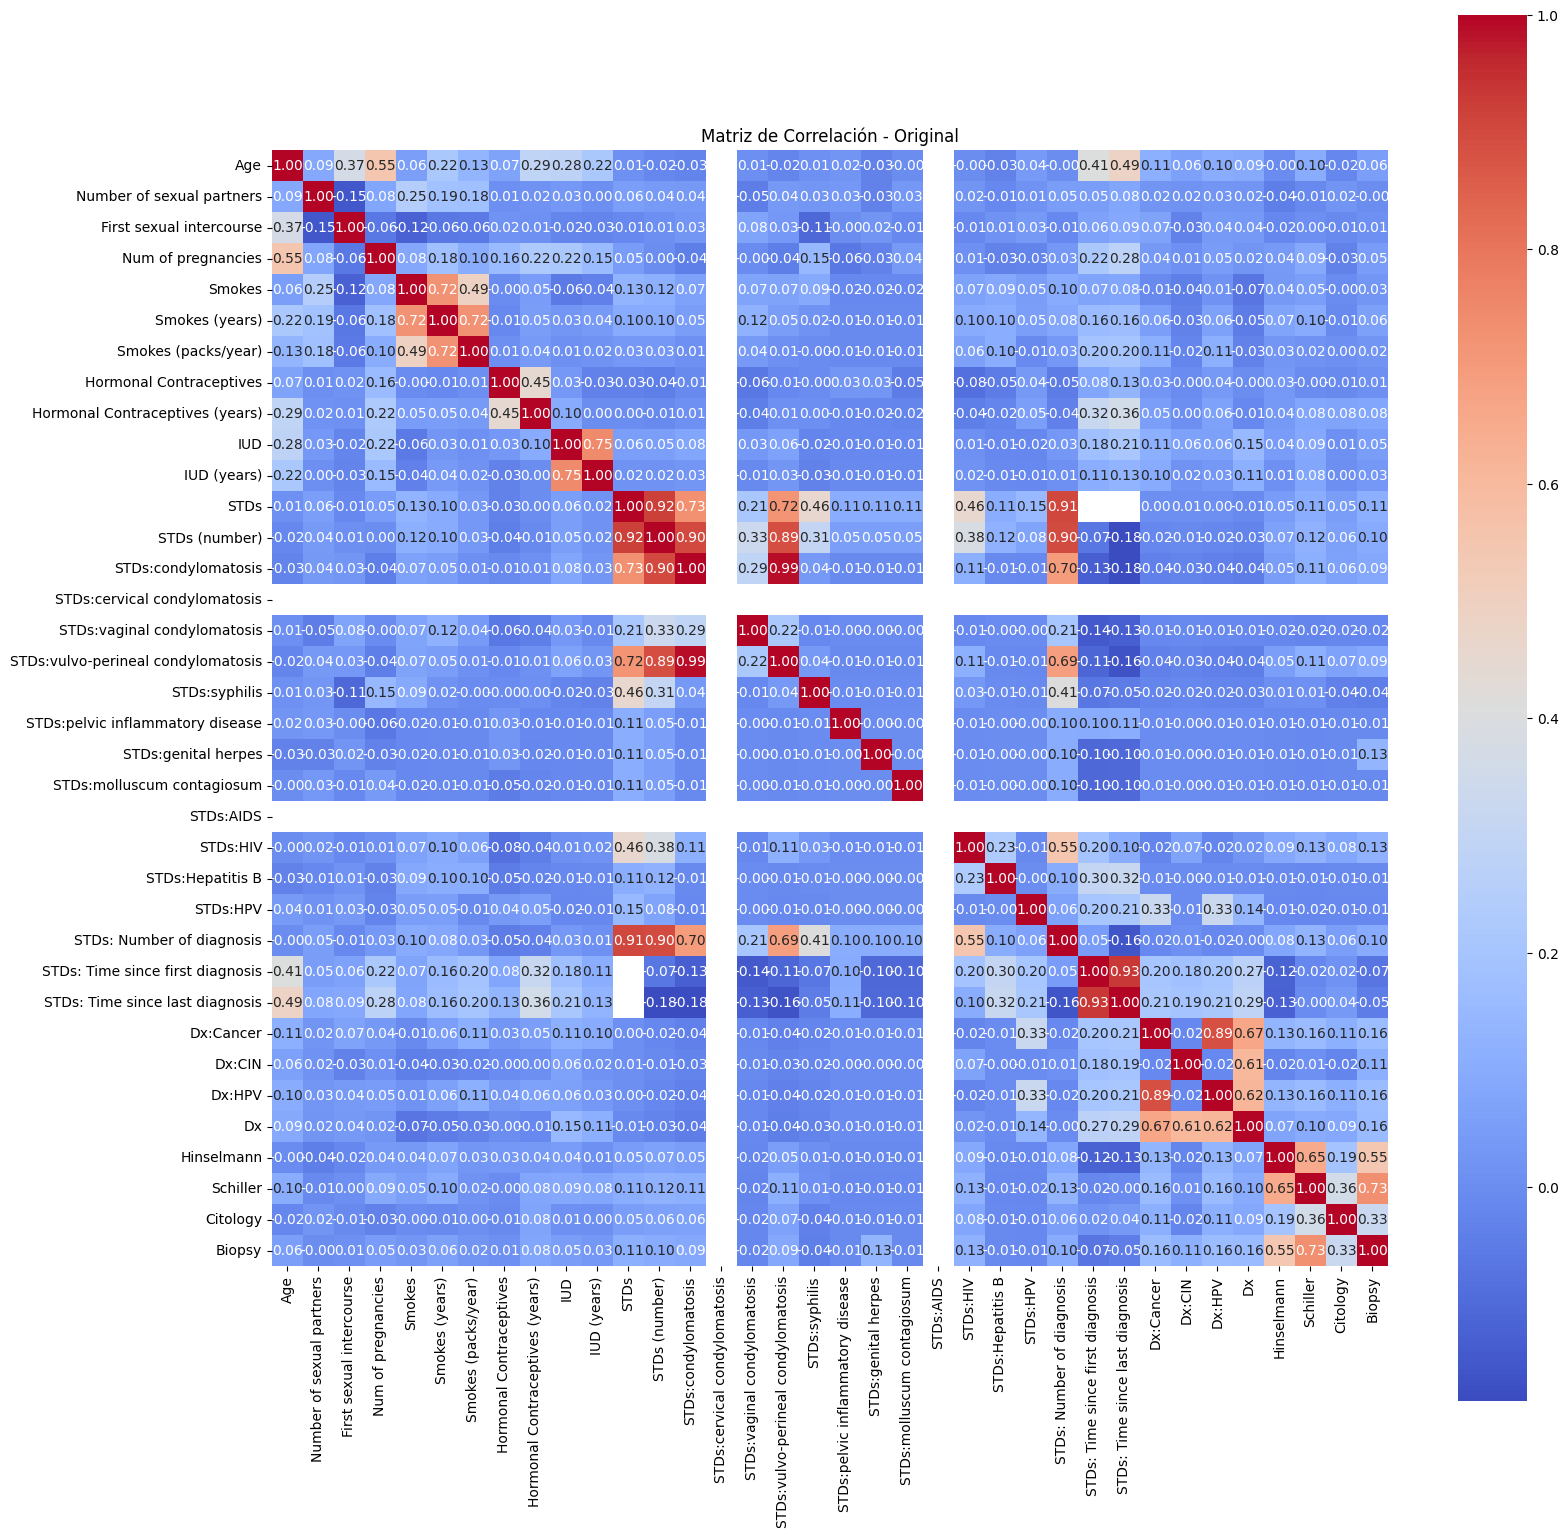

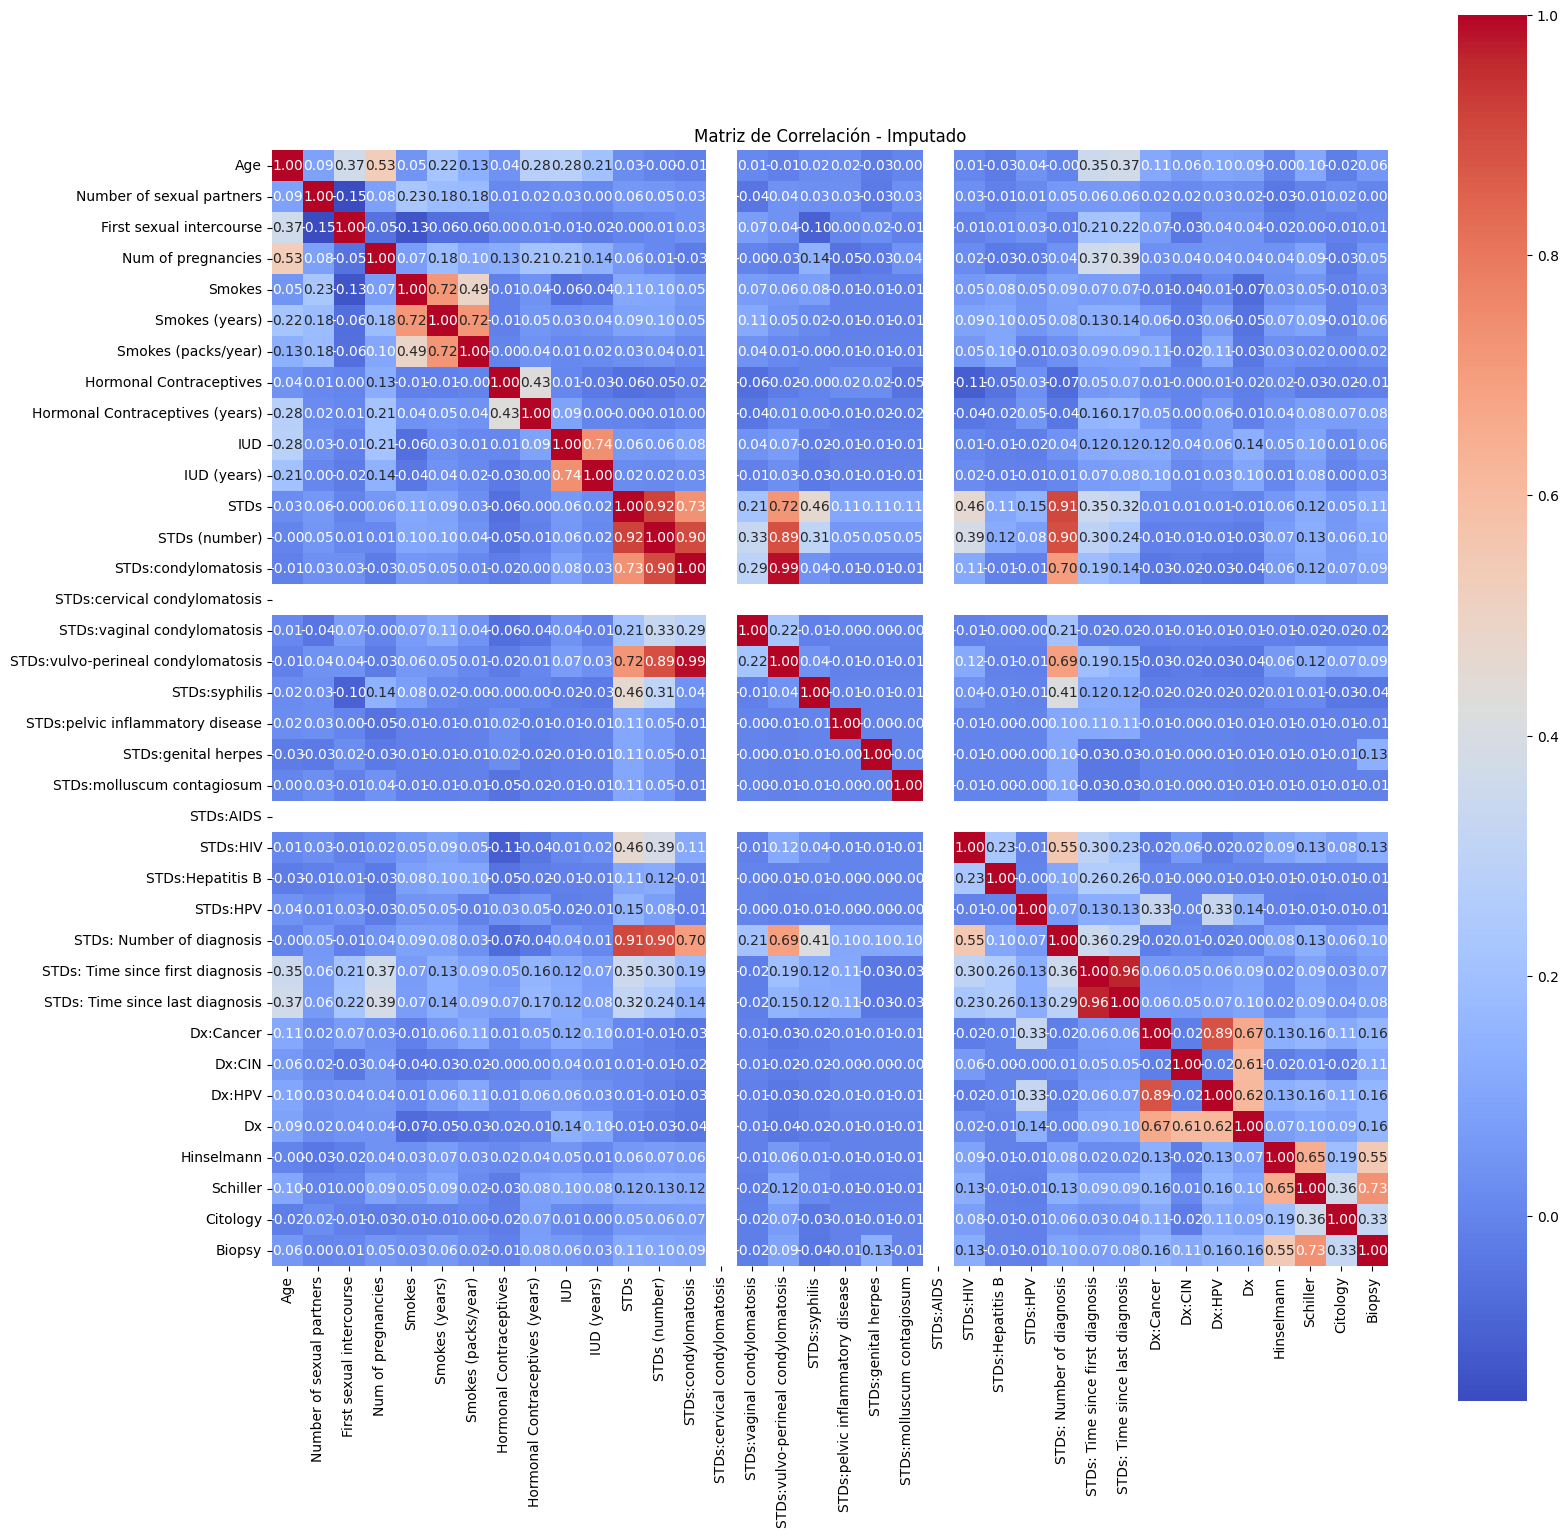

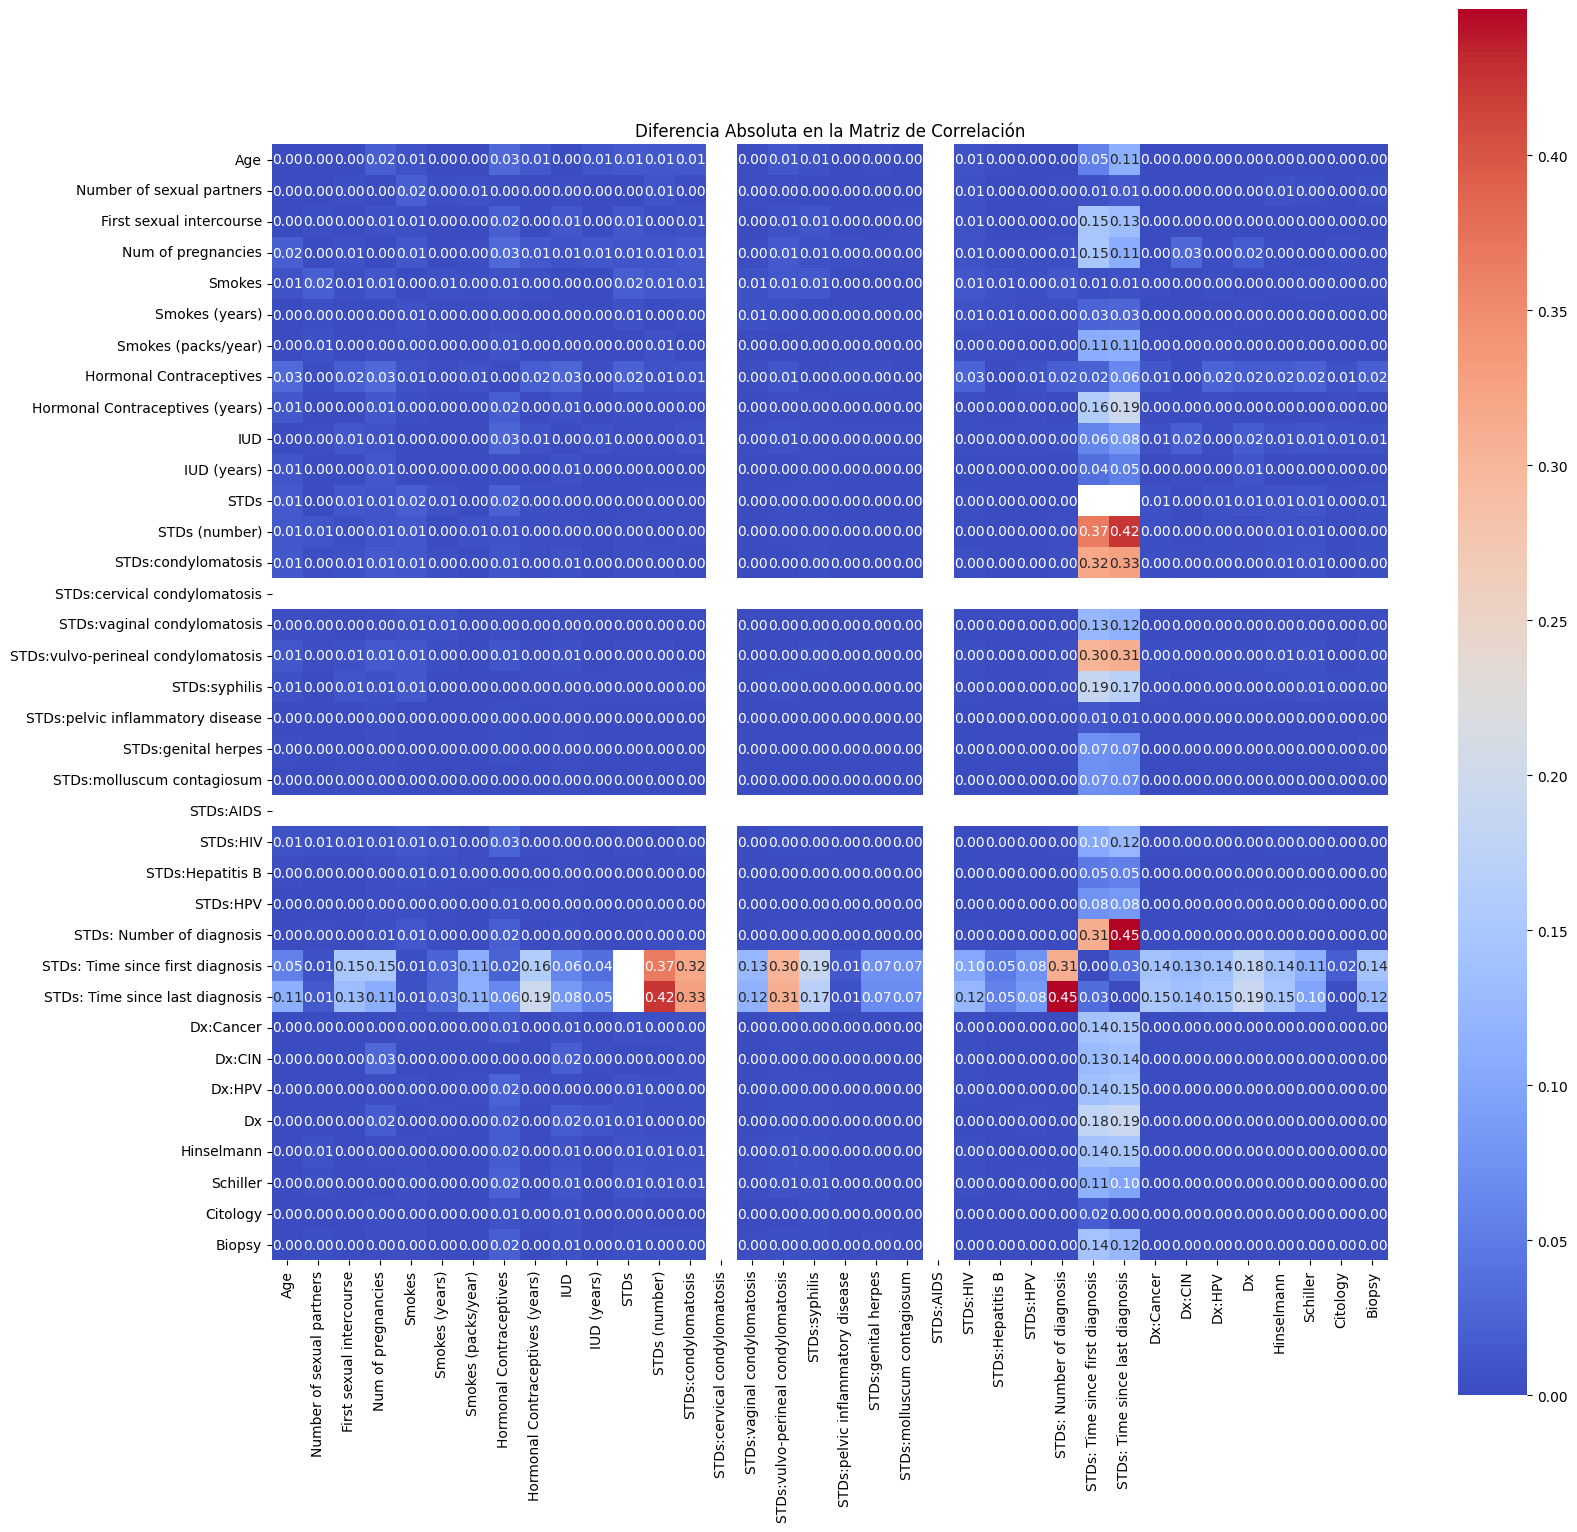

In [24]:
corr_original = df_RFCC.corr()
corr_imputed = df_RFCC_imputed.corr()

# plot of original data
plt.figure(figsize=(18, 18))
sns.heatmap(corr_original, cmap='coolwarm', annot=True, fmt='.2f', cbar=True,
            xticklabels=corr_original.columns, yticklabels=corr_original.columns,
            square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Matriz de Correlación - Original')
plt.show()

# Plot of imputed data
plt.figure(figsize=(18, 18))
sns.heatmap(corr_imputed, cmap='coolwarm', annot=True, fmt='.2f', cbar=True,
            xticklabels=corr_imputed.columns, yticklabels=corr_imputed.columns,
            square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Matriz de Correlación - Imputado')
plt.show()

# Absolute difference
diff_corr = (corr_original - corr_imputed).abs()
plt.figure(figsize=(18, 18))
sns.heatmap(diff_corr, cmap='coolwarm', annot=True, fmt='.2f', cbar=True,
            xticklabels=diff_corr.columns, yticklabels=diff_corr.columns,
            square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Diferencia Absoluta en la Matriz de Correlación')
plt.show()



Podemos observar mediante las matrices de correlación, en especial en la que se muestra la diferencia absoluta entre el conjunto de datos original y el imputado, que la correlación se mantiene para todas las variables, exceptuando para las variables correspondientes a *STDs: Time since last diagnosis* y *STDs: Time since first diagnosis*

Por último, se valida que los datos se encuentren balanceados.


In [25]:
(55/803)*100

6.8493150684931505

In [26]:
df_RFCC_imputed['Biopsy'].value_counts()

Biopsy
0    803
1     55
Name: count, dtype: int64

<Axes: xlabel='Biopsy', ylabel='count'>

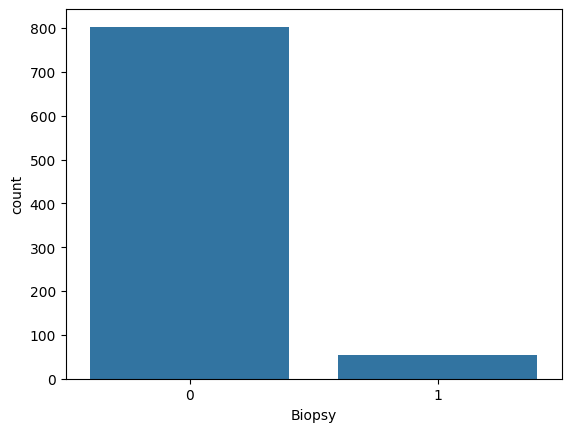

In [27]:
sns.countplot(x=df_RFCC_imputed['Biopsy'])

# Modelos

## Segmentacion de datos

Primero se procede a segmentar los datos y posteriormente, dado que las observaciones no estan balanceadas, se procede a utilizar una técnica de over-Sampling sobre el conjunto de entrenamiento. La técnica a implementar es SMOTE (Synthetic Minority Oversampling Technique) la cual consiste en sintetizar elementos para la clase de menor muestras a partir de las muestras existentes, donde se escoge aleatoriamente un punto de la clase minoritaria y se calculan los k vecinos más cercanos. De esta forma, se añade este nuevo punto elegido y sus vecinos.

In [28]:
X = df_RFCC_imputed.drop('Biopsy', axis=1)
y = df_RFCC_imputed['Biopsy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<Axes: xlabel='Biopsy', ylabel='count'>

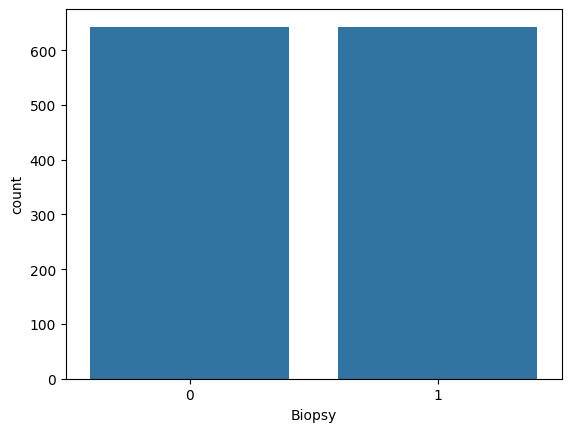

In [29]:
smote = SMOTE(sampling_strategy='auto')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

sns.countplot(x=y_sm)

In [30]:
results = []
y_prob = {}

C:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


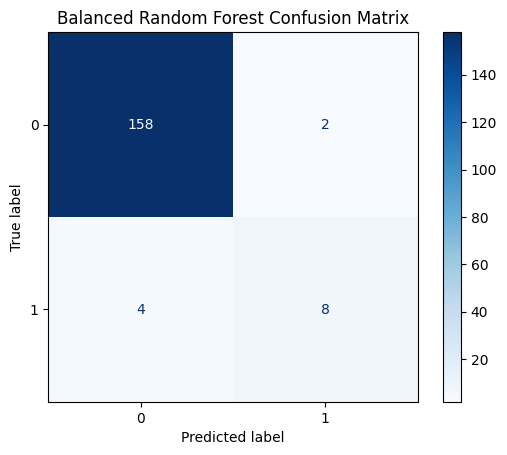

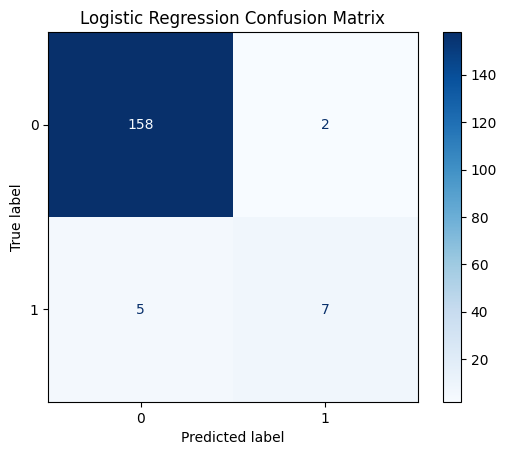

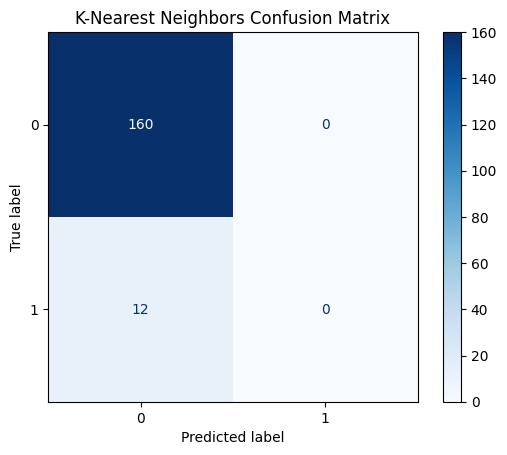

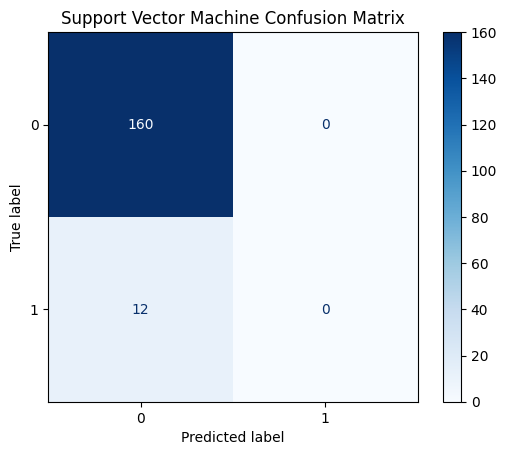

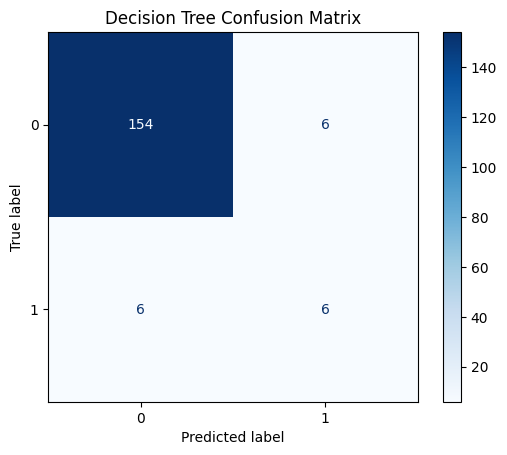

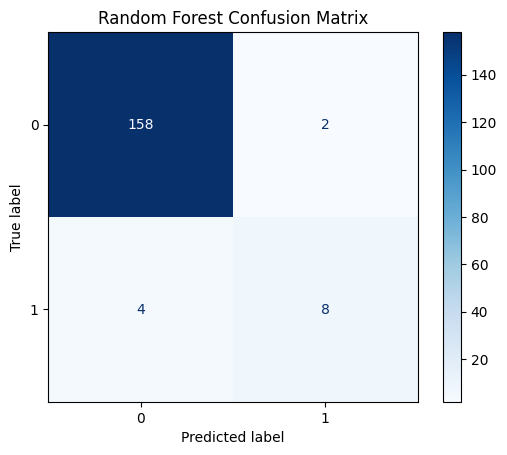

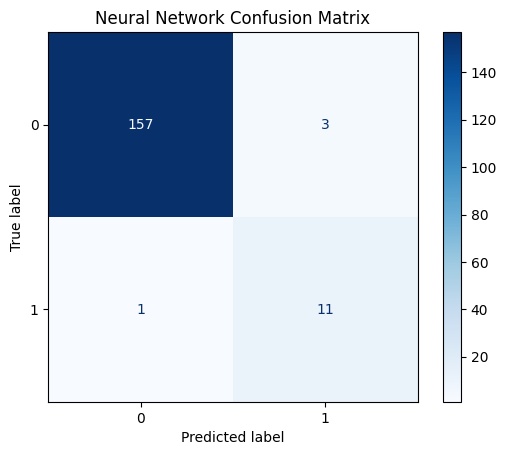

In [31]:
# Init classifiers
classifiers = {
    'Balanced Random Forest': BalancedRandomForestClassifier(sampling_strategy='not majority', replacement=False),
    'Logistic Regression': LogisticRegression(max_iter=1_000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=1_000)
}

# Train and test each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob[f"{name} with unbalance data"] = clf.predict_proba(X_test)[:,1]
    report = classification_report(y_test,y_pred, zero_division=0, output_dict=True)
    # Store results
    results.append({
        "Model": f"{name} with unbalance data",
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score'],
        "Support": report['weighted avg']['support']
    })
    # Confusion Matrix of each classifier
    disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
    disp.ax_.set_title(f'{name} Confusion Matrix')
    plt.show()

C:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


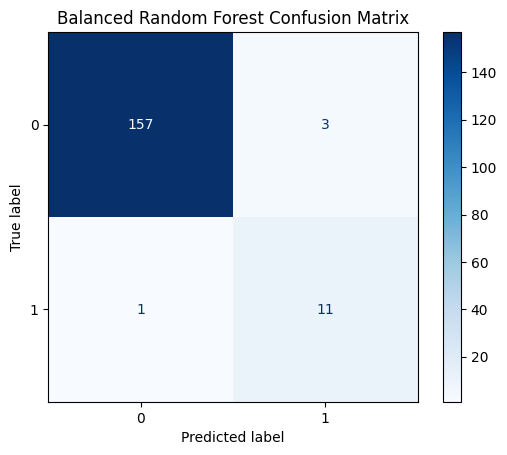

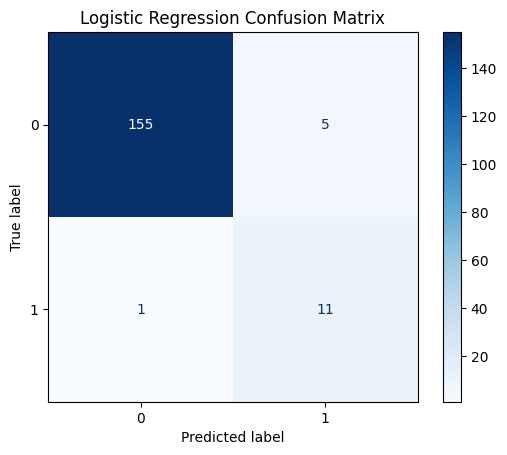

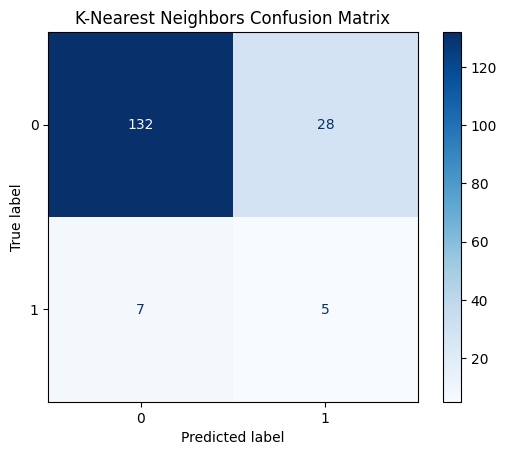

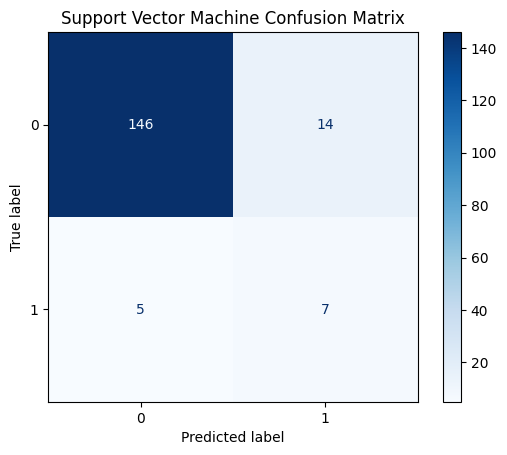

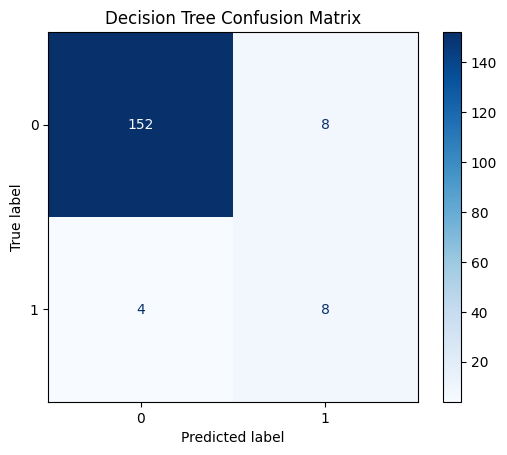

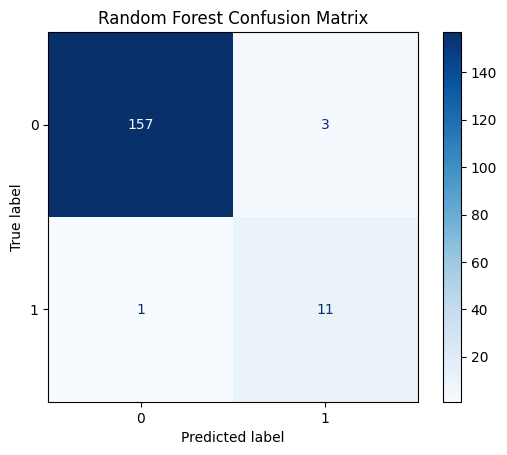

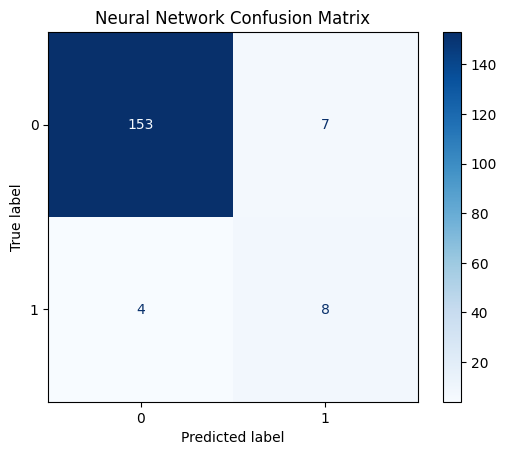

In [32]:
# Init classifiers
classifiers = {
    'Balanced Random Forest': BalancedRandomForestClassifier(sampling_strategy='not majority', replacement=False),
    'Logistic Regression': LogisticRegression(max_iter=1_000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=1_000)
}

# Train and test each classifier
for name, clf in classifiers.items():
    clf.fit(X_sm, y_sm)
    y_pred = clf.predict(X_test)
    y_prob[f"{name} with balance data"] = clf.predict_proba(X_test)[:,1]
    report = classification_report(y_test,y_pred, zero_division=0, output_dict=True)
    # Store results
    results.append({
        "Model": f"{name} with balance data",
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score'],
        "Support": report['weighted avg']['support']
    })
    # Confusion Matrix of each classifier
    disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
    disp.ax_.set_title(f'{name} Confusion Matrix')
    plt.show()

In [33]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-Score', ascending=False)
results_df

Model  Precision    Recall  F1-Score  \
7     Balanced Random Forest with balance data   0.979162  0.976744  0.977566   
6           Neural Network with unbalance data   0.979162  0.976744  0.977566   
12             Random Forest with balance data   0.979162  0.976744  0.977566   
8        Logistic Regression with balance data   0.972235  0.965116  0.967387   
0   Balanced Random Forest with unbalance data   0.963078  0.965116  0.963639   
5            Random Forest with unbalance data   0.963078  0.965116  0.963639   
1      Logistic Regression with unbalance data   0.955961  0.959302  0.956584   
13            Neural Network with balance data   0.943742  0.936047  0.939297   
11             Decision Tree with balance data   0.941264  0.930233  0.934774   
4            Decision Tree with unbalance data   0.930233  0.930233  0.930233   
10    Support Vector Machine with balance data   0.922686  0.889535  0.903000   
3   Support Vector Machine with unbalance data   0.865333  0.930233  0.896610   
2      K-Nearest Neighbors with unbalance data   0.865333  0.930233  0.896610   
9        K-Nearest Neighbors with balance data   0.893957  0.796512  0.836846   

    Support  
7     172.0  
6     172.0  
12    172.0  
8     172.0  
0     172.0  
5     172.0  
1     172.0  
13    172.0  
11    172.0  
4     172.0  
10    172.0  
3     172.0  
2     172.0  
9     172.0

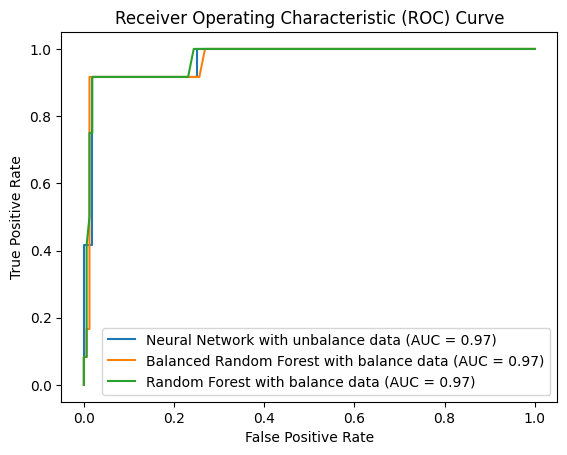

In [34]:
plt.figure()
for model, probabilities in y_prob.items():
    if model in results_df['Model'].values[:3]:
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

Analizando de manera conjunta los diferentes indicadores, podemos centrarnos en los modelos con mejor desempeño. Se realizará un análisis de los intervalos de confianza que puede generar estos modelos para validar su robustez y seleccionar adecuadamente el mejor.

El algoritmo implementado consiste en tomar muestras aleatorias de los datos de tamaño n*80% donde n es la cantidad de observaciones y, con ello, realizar el entrenamiento del modelo. Como datos de prueba se utilizan los datos sin considerar y se evalúa el modelo usando como métrica el *accuracy* y el *F1-Score*. Este proceso se repite 5.000 veces y en cada iteración se almacena el valor de *F1-Score* correspondiente. Adicionalmente, dado que los datos no se encuentran balanceados como hemos visto a lo largo de este notebook y con el fin de verificar el posible sesgo a una clase, también consideramos el *accuracy* correspondiente a cada una de las clases.

In [35]:
execute_bootstrap = False

In [36]:
if execute_bootstrap:
    n = 1_000
    sample_size = int(len(df_RFCC_imputed)*0.8)
    
    f1_list_rf = []
    accuracy_list_rf = []
    accuracy_0_list_rf = []
    accuracy_1_list_rf = []
    
    f1_list_nn = []
    accuracy_list_nn = []
    accuracy_0_list_nn = []
    accuracy_1_list_nn = []
    
    f1_list_brf = []
    accuracy_list_brf = []
    accuracy_0_list_brf = []
    accuracy_1_list_brf = []
    
    idxs = np.array([i for i in range(len(df_RFCC_imputed))])
    
    X, y = df_RFCC_imputed.drop('Biopsy', axis=1), df_RFCC_imputed['Biopsy']
    
    for i in range(n):
        # take a sample of n/2 and split it in train and test
        X_train_sample = resample(X, n_samples=sample_size)
        y_train_sample = y[X_train_sample.index]
        idx_test = np.delete(idxs, X_train_sample.index)
        X_test_sample = X.iloc[idx_test]
        y_test_sample = y[idx_test]
    
        # Oversampling train data
        smote = SMOTE(sampling_strategy='auto')
        X_sm_train_sample, y_sm_train_sample = smote.fit_resample(X_train_sample, y_train_sample)
    
        # Train and test classifier - RandomForest
        classifier_rf = RandomForestClassifier()
        classifier_rf.fit(X_sm_train_sample, y_sm_train_sample)
        y_pred_sample_rf = classifier_rf.predict(X_test_sample)
        # Calculate metrics
        accuracy_rf = accuracy_score(y_test_sample, y_pred_sample_rf)
        f1_rf = f1_score(y_test_sample, y_pred_sample_rf)
        confussion_matrix_aux = confusion_matrix(y_test_sample, y_pred_sample_rf)
        acc_class_rf = confussion_matrix_aux.diagonal()/confussion_matrix_aux.sum(axis=1)
        # Store results
        f1_list_rf.append(f1_rf)
        accuracy_list_rf.append(accuracy_rf)
        accuracy_0_list_rf.append(acc_class_rf[0])
        accuracy_1_list_rf.append(acc_class_rf[1])
    
        # Train and test classifier - Neural Network
        classifier_nn = MLPClassifier(max_iter=1_000)
        classifier_nn.fit(X_sm_train_sample, y_sm_train_sample)
        y_pred_sample_nn = classifier_nn.predict(X_test_sample)
        # Calculate metrics
        accuracy_nn = accuracy_score(y_test_sample, y_pred_sample_nn)
        f1_nn = f1_score(y_test_sample, y_pred_sample_nn)
        confussion_matrix_aux = confusion_matrix(y_test_sample, y_pred_sample_nn)
        acc_class_nn = confussion_matrix_aux.diagonal()/confussion_matrix_aux.sum(axis=1)
        # Store results
        f1_list_nn.append(f1_nn)
        accuracy_list_nn.append(accuracy_nn)
        accuracy_0_list_nn.append(acc_class_nn[0])
        accuracy_1_list_nn.append(acc_class_nn[1])
    
        # Train and test classifier - Balanced Random Forest
        classifier_brf = BalancedRandomForestClassifier(sampling_strategy='not majority', bootstrap=False, replacement=False)
        classifier_brf.fit(X_sm_train_sample, y_sm_train_sample)
        y_pred_sample_brf = classifier_brf.predict(X_test_sample)
        # Calculate metrics
        accuracy_brf = accuracy_score(y_test_sample, y_pred_sample_brf)
        f1_brf = f1_score(y_test_sample, y_pred_sample_brf)
        confussion_matrix_aux = confusion_matrix(y_test_sample, y_pred_sample_brf)
        acc_class_brf = confussion_matrix_aux.diagonal()/confussion_matrix_aux.sum(axis=1)
        # Store results
        f1_list_brf.append(f1_brf)
        accuracy_list_brf.append(accuracy_brf)
        accuracy_0_list_brf.append(acc_class_brf[0])
        accuracy_1_list_brf.append(acc_class_brf[1])
    
    # Save results data
    rf_info = [f1_list_rf, accuracy_list_rf, accuracy_0_list_rf, accuracy_1_list_rf]
    nn_info = [f1_list_nn, accuracy_list_nn, accuracy_0_list_nn, accuracy_1_list_nn]
    brf_info = [f1_list_brf, accuracy_list_brf, accuracy_0_list_brf, accuracy_1_list_brf]
    
    info_data = {
        "RandomForest Results": rf_info,
        "NeuralNetwork Results": nn_info,
        "BalancedRandomForest Results": brf_info
    }
    
    with open("models_results.json", "w") as file:
        json.dump(info_data, file, indent=4)

In [37]:
def plot_histograms(f1_list, accuracy_list, accuracy_0_list, accuracy_1_list, general_title):
    coef_intervals_f1 = stats.t.interval(0.95, len(f1_list)-1,loc=np.mean(f1_list), scale=stats.sem(f1_list))
    coef_intervals_acc = stats.t.interval(0.95, len(accuracy_list)-1,loc=np.mean(accuracy_list), scale=stats.sem(accuracy_list))
    coef_intervals_cl0 = stats.t.interval(0.95, len(accuracy_0_list)-1, loc=np.mean(accuracy_0_list), scale=stats.sem(accuracy_0_list))
    coef_intervals_cl1 = stats.t.interval(0.95, len(accuracy_1_list)-1, loc=np.mean(accuracy_1_list), scale=stats.sem(accuracy_1_list))

    titles_intervals = ['F1-Score', 'Accuracy', 'Accuracy class 0', 'Accuracy class 1']
    coef_intervals = [coef_intervals_f1, coef_intervals_acc, coef_intervals_cl0, coef_intervals_cl1]
    metrics_list = [f1_list, accuracy_list, accuracy_0_list, accuracy_1_list]

    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    for i in range(4):
        ax[i].hist(metrics_list[i])
        ax[i].axvline(x = coef_intervals[i][0], color = 'blue', linestyle ='--')
        ax[i].axvline(x = coef_intervals[i][1], color = 'blue', linestyle ='--')
        ax[i].axvline(x = np.mean(coef_intervals[i]), color = 'blue', linestyle ='-')
        ax[i].set_title(titles_intervals[i])
        ax[i].legend([f'Intevalos ({round(coef_intervals[i][0],5)}, {round(coef_intervals[i][1],5)})'])
    fig.suptitle(general_title)
    plt.show()

In [38]:
with open("models_results.json", "r") as file:
    data_results = json.load(file)

f1_list_rf, accuracy_list_rf, accuracy_0_list_rf, accuracy_1_list_rf = data_results["RandomForest Results"]
f1_list_nn, accuracy_list_nn, accuracy_0_list_nn, accuracy_1_list_nn = data_results["NeuralNetwork Results"]
f1_list_brf, accuracy_list_brf, accuracy_0_list_brf, accuracy_1_list_brf = data_results["BalancedRandomForest Results"]

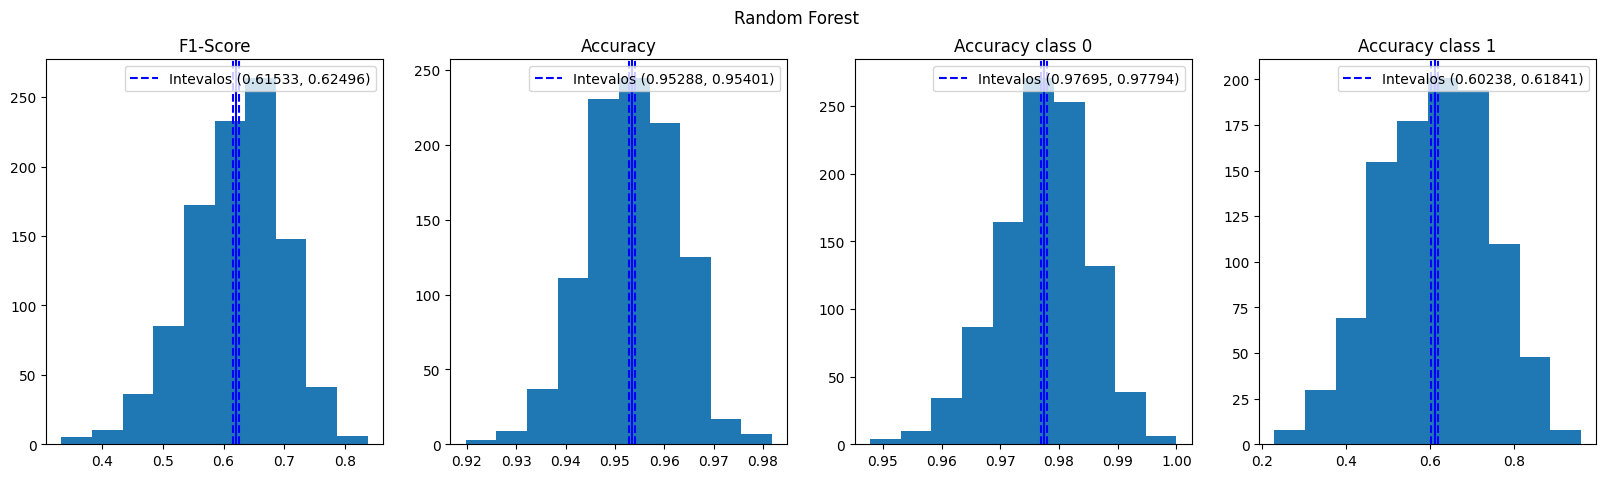

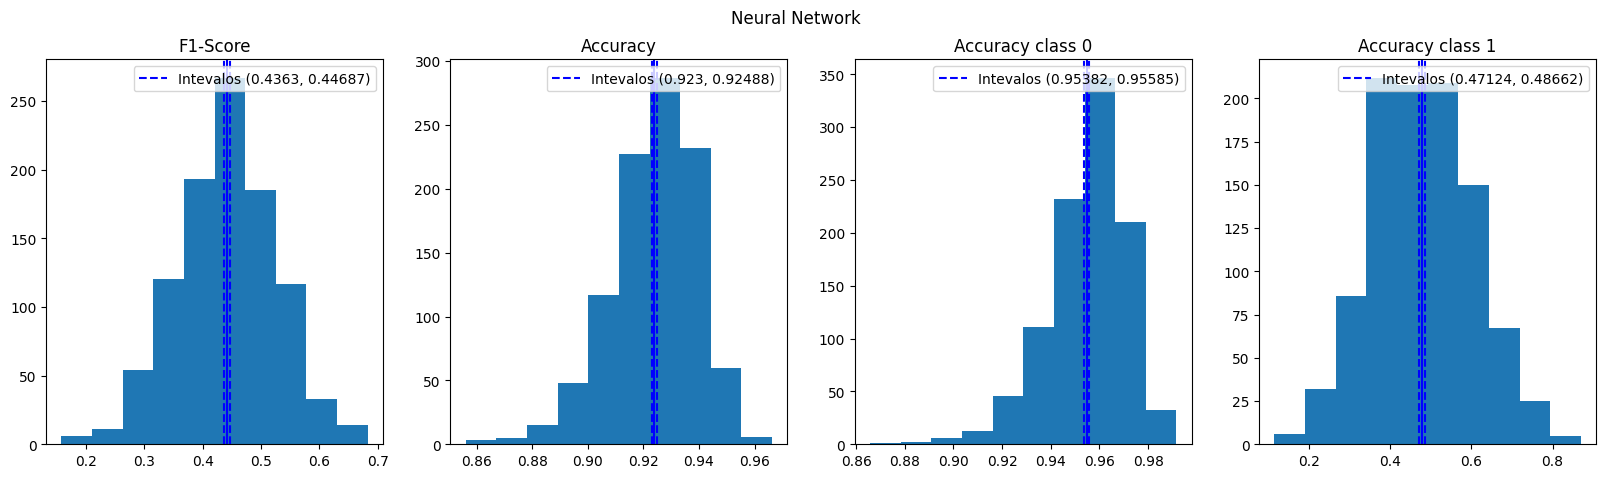

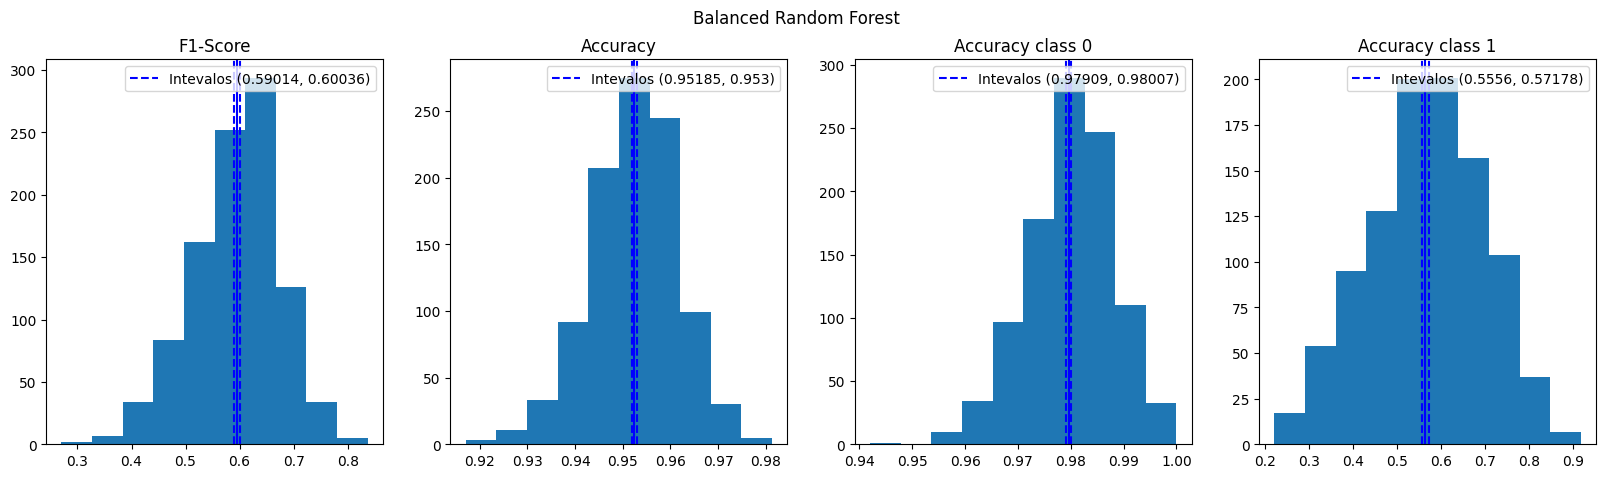

In [39]:
plot_histograms(f1_list_rf, accuracy_list_rf, accuracy_0_list_rf, accuracy_1_list_rf, 'Random Forest')
plot_histograms(f1_list_nn, accuracy_list_nn, accuracy_0_list_nn, accuracy_1_list_nn, 'Neural Network')
plot_histograms(f1_list_brf, accuracy_list_brf, accuracy_0_list_brf, accuracy_1_list_brf, 'Balanced Random Forest')

Podemos observar entonces que el modelo que mejor desempeño tiene, considerando las diferentes métricas junto con sus intervalos de confianza, los cuales de manera general para los modelos y estadísticos evaluados siguen una distribución normal, es **RandomForest**.

Sin embargo, como se puede observar, el método de balanceo implementado no logra solventar en un porcentaje significativo el sesgo generado por la clase 0, por lo cual, no se puede afirmar un buen comportamiento del modelo bajo diferentes situaciones. 

Para entender de mejor manera el comportamiento del modelo, se realizará una gráfica de la relevancia de las características consideradas en el modelo. 

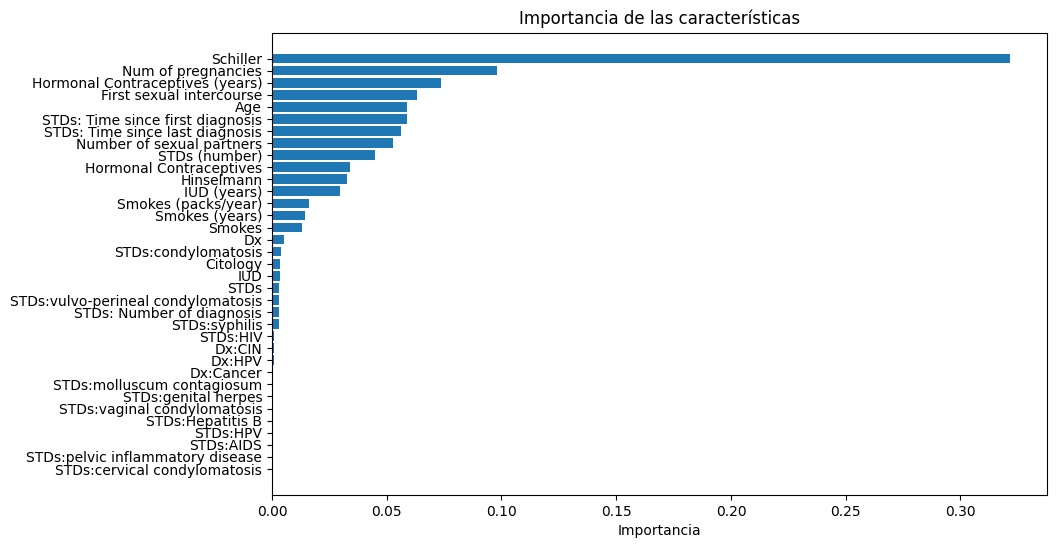

In [40]:
# Random Forest Model
rf = RandomForestClassifier()
rf.fit(X_sm, y_sm)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)


# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), X_sm.columns[indices])
plt.xlabel("Importancia")
plt.show()

In [41]:
print("Numero de caracteristicas con importancia superior a 0.05: ", len(np.where(importances>0.05)[0]))
print("Numero de caracteristicas con importancia superior a 0.01: ", len(np.where(importances>0.01)[0]))

Numero de caracteristicas con importancia superior a 0.05:  8
Numero de caracteristicas con importancia superior a 0.01:  15


Podemos observar que de las 35 características consideradas, únicamente 15 de ellas tienen una importancia mayor a 0.01 y solo 9 mayores a 0.05.

Bajo el análisis propuesto en el presente notebook y los requisitos que se tuvieron en cuenta, este es el modelo con mejores resultados. Donde el modelo propuesto, puede predecir con un 10% más de probabilidad la posibilidad de que una persona tenga cáncer dada su historia clínica (características consideradas).

Como propuesta adicional, se realizará un análisis de componentes principales, una estandarización de las características y se evaluará el rendimiento del modelo realizando una reducción de características. 

Accuracy: 0.9476744186046512
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       161
           1       0.56      0.91      0.69        11

    accuracy                           0.95       172
   macro avg       0.77      0.93      0.83       172
weighted avg       0.97      0.95      0.95       172



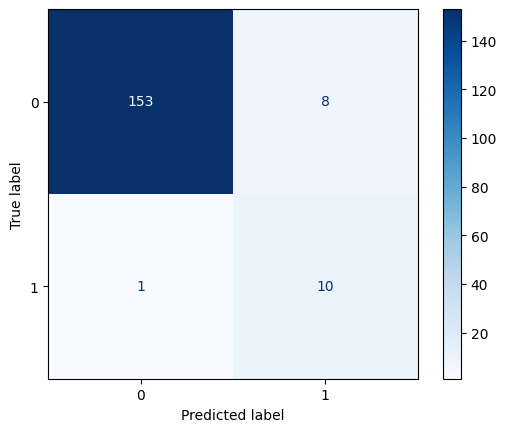

In [44]:
X = df_RFCC_imputed.drop(columns=['Biopsy'])  # Features
y = df_RFCC_imputed['Biopsy']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),                    # Standardize the data
    ('smote', SMOTE(random_state=45)),               # Apply SMOTE to balance the data
    ('pca', PCA(n_components=9)),                    # Perform PCA
    ('rf', RandomForestClassifier(random_state=45))  # Train Random Forest
])

# Step 3: Train the model
pipeline.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')